Se creará una red completa, en ella se programará la dinámica combinada de Scatà et al.

Se creará una red completa con el mismo número de nodos por cada estrategia.
Cada nodo jugará el juego de la corrupción con los nodos restantes.

La dinámica debe recrear los resultados del modelo del replicador vistos en la sección 4.2

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots 
import os
from collections import Counter # Para contar estrategias fácilmente

# --- Parámetros del Juego de la Corrupción ---
# (Estos se pasarán a la función de simulación)

PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
#Parametros para el caso mexicano, p > q, s < q + d < p, q + d << p, 0 < c << 1
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

# --- Funciones  ---

def crear_red_completa(n):
    """Crea una red completa con n nodos."""
    return nx.complete_graph(n)

def inicializar_estrategias_corrupcion(n, estrategias_map=None):
    """Inicializa las 4 estrategias (C, D, H, K) equitativamente."""
    if n % 4 != 0:
        print("Advertencia: El número de nodos no es divisible por 4. La distribución no será exactamente equitativa.")

    nodos_por_estrategia = n // 4
    estrategias = {}
    nodos = list(range(n))
    random.shuffle(nodos) # Mezclar para asignación aleatoria si se prefiere, aunque aquí es secuencial

    idx = 0
    for i in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'C'
        idx += 1
    for i in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'D'
        idx += 1
    for i in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'H'
        idx += 1
    # Los restantes son K
    while idx < n:
         estrategias[nodos[idx]] = 'K'
         idx += 1

    return estrategias

def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    """Calcula el pago para el jugador i contra el jugador j en el Juego de la Corrupción."""
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']

    payoffs = {
        # (Strat_i, Strat_j): Pago_i
        ('C', 'C'): r,    ('C', 'D'): -s,   ('C', 'H'): r,    ('C', 'K'): -s,
        ('D', 'C'): t,    ('D', 'D'): 0,    ('D', 'H'): t-p,  ('D', 'K'): -p,
        ('H', 'C'): r,    ('H', 'D'): -s-c, ('H', 'H'): r,    ('H', 'K'): -s-d,
        ('K', 'C'): t,    ('K', 'D'): -c,   ('K', 'H'): t-q,  ('K', 'K'): -q-d,
    }
    return payoffs.get((strat_i, strat_j), 0) # Devuelve 0 si hay alguna combinación inesperada

def actualizar_estrategia_corrupcion(red, nodo, estrategias, recompensas_totales, K):
    """
    Actualiza la estrategia de un nodo utilizando la regla de Fermi,
    comparando su recompensa total con la de otro nodo elegido al azar.
    SIN HOMOFILIA.
    """
    estrategia_actual = estrategias[nodo]
    recompensa_total_actual = recompensas_totales[nodo]

    # Elegir OTRO nodo al azar (cualquiera en la red completa)
    posibles_vecinos = [n for n in red.nodes() if n != nodo]
    if not posibles_vecinos: # Si solo hay un nodo
         return estrategia_actual
    otro_nodo = random.choice(posibles_vecinos)

    estrategia_otro = estrategias[otro_nodo]
    recompensa_total_otro = recompensas_totales[otro_nodo]

    # Aplicar regla de Fermi (simplificada, sin homofilia)
    try:
        if K <= 1e-9: # Evitar división por cero o K muy pequeño
             probabilidad_adoptar = 1.0 if recompensa_total_otro > recompensa_total_actual else 0.0
        else:
            # Escalar diferencia para evitar overflow en exp()
            delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_otro) / K, -700, 700)
            probabilidad_adoptar = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError):
         # Si aún así hay error, adoptar la estrategia con mayor recompensa
        probabilidad_adoptar = 1.0 if recompensa_total_otro > recompensa_total_actual else 0.0


    if random.random() < probabilidad_adoptar:
        return estrategia_otro
    else:
        return estrategia_actual

def ejecutar_simulacion_corrupcion(
    num_nodos=0,
    params_juego=PARAMS_MEXICO, # Parámetros de la matriz de pagos
    K=0.0, # Nivel de ruido/incertidumbre en la adopción
    rondas=15,
    seed=None
    ):
    """
    Ejecuta la simulación del Juego de la Corrupción en una red completa.
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    print(f"Creando red completa con {num_nodos} nodos...")
    red = crear_red_completa(num_nodos)
    print("Inicializando estrategias (C, D, H, K)...")
    estrategias = inicializar_estrategias_corrupcion(num_nodos)

    # Diccionario para guardar la historia de las fracciones de cada estrategia
    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}
    nodos_lista = list(red.nodes()) # Lista de nodos para eficiencia

    print(f"Iniciando {rondas} rondas de simulación...")
    for r in range(rondas):
        # 1. Calcular recompensas totales para todos los nodos
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for i_idx, nodo_i in enumerate(nodos_lista):
            strat_i = estrategias[nodo_i]
            # Juega contra todos los demás
            for j_idx, nodo_j in enumerate(nodos_lista):
                if i_idx == j_idx:
                    continue # No juega contra sí mismo
                strat_j = estrategias[nodo_j]
                recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)

        # 2. Intentar actualizar estrategia para cada nodo (guardar en dict temporal)
        siguientes_estrategias = {}
        for nodo in nodos_lista:
            siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion(
                red, nodo, estrategias, recompensas_totales, K
            )

        # 3. Aplicar las nuevas estrategias para la siguiente ronda
        estrategias = siguientes_estrategias

        # 4. Registrar fracción de cada estrategia
        conteo_actual = Counter(estrategias.values())
        for strat in ['C', 'D', 'H', 'K']:
            historia_fracciones[strat].append(conteo_actual.get(strat, 0) / num_nodos)

        # Opcional: Imprimir progreso cada X rondas
        if (r + 1) % 50 == 0:
             print(f"  Ronda {r+1}/{rondas} completada.")
             # print(f"    Fracciones: C={historia_fracciones['C'][-1]:.2f}, D={historia_fracciones['D'][-1]:.2f}, H={historia_fracciones['H'][-1]:.2f}, K={historia_fracciones['K'][-1]:.2f}")


    print("Simulación completada.")
    return historia_fracciones

def graficar_evolucion_corrupcion(historia_fracciones, titulo, filename):
    """Grafica la evolución de las 4 estrategias a lo largo del tiempo."""
    plt.style.use(['science', 'ieee']) # Estilo de gráfica científica
    plt.figure(figsize=(3, 3)) # Tamaño ajustado para 4 líneas

    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'} # Colores distintivos
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'} # Estilos de línea distintivos
    nombres_legenda = {
        'C': 'Civiles cooperadores (C)',
        'D': 'Civiles no cooperadores (D)',
        'H': 'Poder Honrado (H)',
        'K': 'Poder Corrupto (K)'
    }


    rondas_totales = len(historia_fracciones['C']) # Asumiendo que todas tienen la misma longitud
    eje_x = range(rondas_totales)

    for strat in ['C', 'D', 'H', 'K']:
        plt.plot(
            eje_x,
            historia_fracciones[strat],
            label=nombres_legenda[strat],
            color=colores[strat],
            linestyle=estilos[strat]
        )

    plt.xlabel("Iteraciones")
    plt.ylabel("Porcentaje")
    plt.title(f"Evolución del Juego de la Corrupción\n({titulo})")
    plt.ylim(0, 1) # Eje Y entre 0 y 1 (o 0 y 0.8/0.5 si prefieres como en tu tesis)
    plt.legend(fontsize='medium') # Leyenda más legible
    plt.grid(True, color="#EAEAEA")

    # Guardar la gráfica
    os.makedirs(os.path.dirname(filename), exist_ok=True) # Crear directorio si no existe
    plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight')
    print(f"Gráfica de evolución guardada como '{filename}'")
    plt.close() # Cerrar la figura para liberar memoria


# --- Función Principal para Ejecutar y Graficar ---

def simular_y_graficar_pais(nombre_pais, params_juego, num_nodos, K, rondas, seed, output_dir="Resultados_Corrupcion"):
    """Ejecuta la simulación para un 'país' (conjunto de parámetros) y guarda la gráfica."""

    print(f"\n--- Iniciando simulación para {nombre_pais} ---")
    historia = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos,
        params_juego=params_juego,
        K=K,
        rondas=rondas,
        seed=seed
    )

    nombre_archivo_grafica = os.path.join(output_dir, f"evolucion_{nombre_pais.lower().replace(' ', '_')}.svg")
    graficar_evolucion_corrupcion(historia, nombre_pais, nombre_archivo_grafica)
    print(f"--- Simulación para {nombre_pais} completada ---")
    return historia

# --- Ejemplo de Uso ---

if __name__ == "__main__":
    # Parámetros globales de simulación
    NODOS = 400
    RUIDO_K = 0.00000 # Puedes experimentar con este valor, similar a Scatà et al. (K=0.5) o más bajo
    RONDAS = 15 # Ajusta según necesites para ver convergencia
    SEED_GLOBAL = 42 # Para reproducibilidad
    OUTPUT_DIR_GLOBAL = "Resultados_Juego_Corrupcion"

    # Ejecutar para cada país
    historia_dinamarca = simular_y_graficar_pais("Dinamarca", PARAMS_DINAMARCA, NODOS, RUIDO_K, RONDAS, SEED_GLOBAL, OUTPUT_DIR_GLOBAL)
    historia_singapur = simular_y_graficar_pais("Singapur", PARAMS_SINGAPUR, NODOS, RUIDO_K, RONDAS, SEED_GLOBAL, OUTPUT_DIR_GLOBAL)
    historia_mexico = simular_y_graficar_pais("México", PARAMS_MEXICO, NODOS, RUIDO_K, RONDAS, SEED_GLOBAL, OUTPUT_DIR_GLOBAL)

    print(f"\nTodas las simulaciones completadas. Resultados guardados en '{OUTPUT_DIR_GLOBAL}'.")

    # Opcional: Mostrar las gráficas si estás en un entorno como Jupyter
    try:
        from IPython.display import SVG, display
        print("\nMostrando gráficas generadas:")
        display(SVG(os.path.join(OUTPUT_DIR_GLOBAL, "evolucion_dinamarca.svg")))
        display(SVG(os.path.join(OUTPUT_DIR_GLOBAL, "evolucion_singapur.svg")))
        display(SVG(os.path.join(OUTPUT_DIR_GLOBAL, "evolucion_mexico.svg")))
    except ImportError:
        print("\n(Instala IPython para ver las gráficas directamente aquí si estás en un notebook).")
    except Exception as e:
        print(f"\nNo se pudieron mostrar las gráficas: {e}")

# Se usan otro tipos de red, Barabási-Albert

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots
import os
from collections import Counter
# Opcional para mostrar SVG en notebooks
try:
    from IPython.display import SVG, display
except ImportError:
    SVG, display = None, None

# --- Parámetros del Juego de la Corrupción (sin cambios) ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

# --- Funciones Auxiliares (calcular_pago y inicializar_estrategias sin cambios) ---

def inicializar_estrategias_corrupcion(n, seed=None):
    """Inicializa las 4 estrategias (C, D, H, K) equitativamente."""
    if n % 4 != 0:
        print(f"Advertencia: Número de nodos ({n}) no divisible por 4. Distribución no será exacta.")

    nodos_por_estrategia = n // 4
    estrategias = {}
    nodos = list(range(n))

    # Usar el generador aleatorio de Python para shuffle, inicializado con seed si se provee
    if seed is not None:
        random.seed(seed) # Afecta a random.shuffle
    random.shuffle(nodos)

    idx = 0
    for _ in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'C'; idx += 1
    for _ in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'D'; idx += 1
    for _ in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'H'; idx += 1
    while idx < n: # Asignar restantes a K
        estrategias[nodos[idx]] = 'K'; idx += 1

    # Ordenar por clave (nodo ID) para consistencia, aunque no estrictamente necesario
    estrategias = dict(sorted(estrategias.items()))
    return estrategias

def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    """Calcula el pago para el jugador i contra el jugador j en el Juego de la Corrupción."""
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = {
        ('C', 'C'): r,    ('C', 'D'): -s,   ('C', 'H'): r,    ('C', 'K'): -s,
        ('D', 'C'): t,    ('D', 'D'): 0,    ('D', 'H'): t-p,  ('D', 'K'): -p,
        ('H', 'C'): r,    ('H', 'D'): -s-c, ('H', 'H'): r,    ('H', 'K'): -s-d,
        ('K', 'C'): t,    ('K', 'D'): -c,   ('K', 'H'): t-q,  ('K', 'K'): -q-d,
    }
    return payoffs.get((strat_i, strat_j), 0)

# --- Funciones de Simulación Modificadas ---

def actualizar_estrategia_corrupcion_red(red, nodo, estrategias, recompensas_totales, K):
    """
    Actualiza la estrategia de un nodo utilizando la regla de Fermi,
    comparando su recompensa total con la de un VECINO elegido al azar.
    """
    estrategia_actual = estrategias[nodo]
    recompensa_total_actual = recompensas_totales[nodo]

    # Elegir un VECINO al azar
    vecinos = list(red.neighbors(nodo))
    if not vecinos: # Nodo aislado
         return estrategia_actual
    vecino_elegido = random.choice(vecinos) # <--- Cambio clave: elige entre vecinos

    estrategia_vecino = estrategias[vecino_elegido]
    recompensa_total_vecino = recompensas_totales[vecino_elegido]

    # Aplicar regla de Fermi
    try:
        if K <= 1e-9:
             probabilidad_adoptar = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else:
            delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700)
            probabilidad_adoptar = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError):
        probabilidad_adoptar = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0

    if random.random() < probabilidad_adoptar:
        return estrategia_vecino
    else:
        return estrategia_actual

def ejecutar_simulacion_corrupcion(
    num_nodos=100,
    network_type='completa', # <--- Nuevo: 'completa', 'ba'
    network_params=None,     # <--- Nuevo: dict con params, e.g., {'m': 2} for ba
    params_juego=PARAMS_MEXICO,
    K=0.1,
    rondas=15,
    seed=None
    ):
    """
    Ejecuta la simulación del Juego de la Corrupción en el tipo de red especificado.
    Las interacciones (juego y actualización) ocurren entre vecinos.
    """
    if seed is not None:
        # Asegurar que la creación de la red y la dinámica aleatoria sean reproducibles
        random.seed(seed)
        np.random.seed(seed)
        # NetworkX usa el generador de NumPy para algunos modelos
        # Para otros como BA usa el global de Python (que ya inicializamos)

    # --- Creación de Red Dinámica ---
    print(f"Creando red tipo '{network_type}' con {num_nodos} nodos...")
    if network_type == 'Completa':
        red = nx.complete_graph(num_nodos)
        network_params_str = "" # No necesita parámetros extra
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2) # Default m=2 para BA si no se especifica
        if m >= num_nodos:
             print(f"Advertencia: m ({m}) >= num_nodos ({num_nodos}). Usando m = {max(1, num_nodos // 2)}.")
             m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed) # Usa seed para BA
        network_params_str = f"_(m={m})" # Para nombres de archivo
    # Añadir aquí elif para 'ws', 'er', etc. si se desea
    # elif network_type == 'ws':
    #     if network_params is None: network_params = {}
    #     k_ws = network_params.get('k', 4)
    #     p_ws = network_params.get('p', 0.1)
    #     red = nx.watts_strogatz_graph(num_nodos, k_ws, p_ws, seed=seed)
    #     network_params_str = f"_k{k_ws}_p{p_ws:.1f}".replace('.', '')
    else:
        raise ValueError(f"Tipo de red desconocido: {network_type}")

    print(f"Red creada. Nodos: {red.number_of_nodes()}, Enlaces: {red.number_of_edges()}")
    if not nx.is_connected(red):
         print("Advertencia: La red generada no está conectada.")
         # Podrías decidir tomar el componente gigante aquí si es necesario
         # O simplemente continuar, la dinámica solo ocurrirá dentro de componentes
    # --------------------------------

    print("Inicializando estrategias (C, D, H, K)...")
    # Pasar seed a inicialización para reproducibilidad del shuffle
    estrategias = inicializar_estrategias_corrupcion(num_nodos, seed=seed)

    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}
    nodos_lista = list(red.nodes())

    print(f"Iniciando {rondas} rondas de simulación...")
    for r in range(rondas):
        # 1. Calcular recompensas totales (JUGANDO CON VECINOS)
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]
            vecinos_i = list(red.neighbors(nodo_i)) # <--- Cambio clave
            if not vecinos_i: continue # Saltar nodos aislados
            for nodo_j in vecinos_i: # <--- Iterar solo sobre vecinos
                strat_j = estrategias[nodo_j]
                recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)

        # 2. Actualizar estrategia (BASADO EN VECINOS)
        siguientes_estrategias = {}
        nodos_actualizar = nodos_lista[:] # Copiar lista para posible modificación
        random.shuffle(nodos_actualizar) # Actualizar en orden aleatorio cada ronda
        for nodo in nodos_actualizar:
            siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red( # <--- Usar la función _red
                red, nodo, estrategias, recompensas_totales, K
            )
        estrategias = siguientes_estrategias

        # 3. Registrar fracción de cada estrategia
        conteo_actual = Counter(estrategias.values())
        for strat in ['C', 'D', 'H', 'K']:
            # Manejar caso donde num_nodos podría ser 0 si la red está vacía (improbable)
            fraccion = conteo_actual.get(strat, 0) / num_nodos if num_nodos > 0 else 0
            historia_fracciones[strat].append(fraccion)


        if (r + 1) % 50 == 0:
             print(f"  Ronda {r+1}/{rondas} completada.")

    print("Simulación completada.")
    # Devolver también parámetros usados para el nombre de archivo
    return historia_fracciones, network_type, network_params_str

def graficar_evolucion_corrupcion(historia_fracciones, titulo, network_type_str, filename):
    """Grafica la evolución de las 4 estrategias, añadiendo tipo de red al título."""
    plt.style.use(['science', 'ieee'])
    plt.figure(figsize=(2.5, 2.5)) # Ajustar tamaño si es necesario

    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'}
    nombres_legenda = {
        'C': 'Civiles Cooperadores (C)', 'D': 'Civiles no Cooperadores (D)',
        'H': 'Poder Honrado (H)', 'K': 'Poder Corrupto (K)'
    } # Acortar leyendas

    rondas_totales = len(historia_fracciones['C'])
    eje_x = range(rondas_totales)

    for strat in ['C', 'D', 'H', 'K']:
        plt.plot(eje_x, historia_fracciones[strat], label=nombres_legenda[strat],
                 color=colores[strat], linestyle=estilos[strat], linewidth=1.5) # Líneas un poco más gruesas

    plt.xlabel("Iteraciones")
    plt.ylabel("Porcentaje")
    # Añadir tipo de red al título
    plt.title(f"Evolución de {titulo}\nRed: {network_type_str}")
    plt.ylim(0, 1.0) # Un poco más de margen superior
    plt.xlim(0, rondas_totales -1 if rondas_totales > 1 else 1) # Ajustar límite x
    plt.legend(fontsize='small', loc='best') # Leyenda más pequeña, mejor ubicación
    plt.grid(True, linestyle='--', alpha=0.6) # Rejilla suave

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight')
    print(f"Gráfica de evolución guardada como '{filename}'")
    plt.close()

# --- Función Principal para Ejecutar y Graficar (Modificada) ---

def simular_y_graficar_pais(
    nombre_pais,
    params_juego,
    num_nodos,
    network_type, # <--- Nuevo
    network_params, # <--- Nuevo
    K,
    rondas,
    seed,
    output_dir="Resultados_Corrupcion"
    ):
    """Ejecuta la simulación para un 'país' y tipo de red, guarda la gráfica."""

    print(f"\n--- Iniciando simulación para {nombre_pais} en red tipo '{network_type}' ---")
    historia, net_type_used, net_params_str = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos,
        network_type=network_type, # Pasa el tipo de red
        network_params=network_params, # Pasa los parámetros de red
        params_juego=params_juego,
        K=K,
        rondas=rondas,
        seed=seed
    )

    # Construir nombre de archivo incluyendo tipo de red y parámetros
    nombre_base = f"evolucion_{nombre_pais.lower().replace(' ', '_')}_{net_type_used}{net_params_str}"
    nombre_archivo_grafica = os.path.join(output_dir, f"{nombre_base}.svg")

    # Pasar el string formateado de parámetros para el título
    network_title_str = f"{net_type_used}{net_params_str.replace('_', ' ')}"
    graficar_evolucion_corrupcion(historia, nombre_pais, network_title_str, nombre_archivo_grafica)

    print(f"--- Simulación para {nombre_pais} en red '{network_type}' completada ---")
    return historia, nombre_archivo_grafica # Devolver path para display

# --- Ejemplo de Uso ---

if __name__ == "__main__":
    # Parámetros globales
    NODOS = 100
    RUIDO_K = 0.1 # Explorar valores, e.g., 0.01, 0.1, 0.5
    RONDAS = 16 # Aumentar para ver mejor convergencia
    SEED_GLOBAL = 42
    OUTPUT_DIR_GLOBAL = "Resultados_Juego_Corrupcion_Redes"

    # Definir tipos de red y parámetros a probar
    simulaciones_a_ejecutar = [
        {'network_type': 'Completa', 'network_params': {}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 2}}, # Barabasi-Albert con m=2
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 4}}, # Barabasi-Albert con m=4
        # {'network_type': 'ws', 'network_params': {'k': 4, 'p': 0.1}}, # Ejemplo Watts-Strogatz
    ]

    # Diccionario para guardar paths de las gráficas generadas
    graficas_generadas = {}

    for sim_config in simulaciones_a_ejecutar:
        net_type = sim_config['network_type']
        net_params = sim_config['network_params']

        # Crear subdirectorio por tipo de red
        output_subdir = os.path.join(OUTPUT_DIR_GLOBAL, f"Red_{net_type}{''.join([f'_{k}{v}' for k,v in net_params.items()])}")

        # Ejecutar para cada país con esta configuración de red
        graficas_generadas[f"Dinamarca_{net_type}{net_params}"] = simular_y_graficar_pais(
            "Dinamarca", PARAMS_DINAMARCA, NODOS, net_type, net_params, RUIDO_K, RONDAS, SEED_GLOBAL, output_subdir
        )[1] # Guardar path
        graficas_generadas[f"Singapur_{net_type}{net_params}"] = simular_y_graficar_pais(
            "Singapur", PARAMS_SINGAPUR, NODOS, net_type, net_params, RUIDO_K, RONDAS, SEED_GLOBAL, output_subdir
        )[1] # Guardar path
        graficas_generadas[f"Mexico_{net_type}{net_params}"] = simular_y_graficar_pais(
            "México", PARAMS_MEXICO, NODOS, net_type, net_params, RUIDO_K, RONDAS, SEED_GLOBAL, output_subdir
        )[1] # Guardar path

    print(f"\nTodas las simulaciones completadas. Resultados guardados en subdirectorios dentro de '{OUTPUT_DIR_GLOBAL}'.")

    # Opcional: Mostrar las gráficas si estás en un entorno como Jupyter
    if display and SVG:
        print("\nMostrando gráficas generadas:")
        for nombre, path_grafica in graficas_generadas.items():
             if os.path.exists(path_grafica):
                 print(f"\n--- {nombre.replace('_', ' ')} ---")
                 display(SVG(path_grafica))
             else:
                 print(f"Archivo no encontrado: {path_grafica}")
    elif display is None or SVG is None:
        print("\n(Instala IPython/Jupyter para ver las gráficas directamente aquí).")
    else:
         print("\nNo se pudieron mostrar las gráficas.")

# Se grafican las redes creadas

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots
import os
from collections import Counter
# Opcional para mostrar SVG en notebooks
try:
    from IPython.display import SVG, display
except ImportError:
    SVG, display = None, None

# --- Parámetros del Juego de la Corrupción (sin cambios) ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

# --- Funciones Auxiliares (sin cambios) ---
def inicializar_estrategias_corrupcion(n, seed=None):
    
    if n % 4 != 0:
        print(f"Advertencia: Número de nodos ({n}) no divisible por 4. Distribución no será exacta.")

    nodos_por_estrategia = n // 4
    estrategias = {}
    nodos = list(range(n))

    if seed is not None:
        random.seed(seed)
    random.shuffle(nodos)

    idx = 0
    for _ in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'C'; idx += 1
    for _ in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'D'; idx += 1
    for _ in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'H'; idx += 1
    while idx < n:
        estrategias[nodos[idx]] = 'K'; idx += 1

    estrategias = dict(sorted(estrategias.items()))
    return estrategias

def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    # ... (código igual que antes) ...
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = {
        ('C', 'C'): r,    ('C', 'D'): -s,   ('C', 'H'): r,    ('C', 'K'): -s,
        ('D', 'C'): t,    ('D', 'D'): 0,    ('D', 'H'): t-p,  ('D', 'K'): -p,
        ('H', 'C'): r,    ('H', 'D'): -s-c, ('H', 'H'): r,    ('H', 'K'): -s-d,
        ('K', 'C'): t,    ('K', 'D'): -c,   ('K', 'H'): t-q,  ('K', 'K'): -q-d,
    }
    return payoffs.get((strat_i, strat_j), 0)

def actualizar_estrategia_corrupcion_red(red, nodo, estrategias, recompensas_totales, K):
    estrategia_actual = estrategias[nodo]
    recompensa_total_actual = recompensas_totales[nodo]

    vecinos = list(red.neighbors(nodo))
    if not vecinos:
         return estrategia_actual
    vecino_elegido = random.choice(vecinos)

    estrategia_vecino = estrategias[vecino_elegido]
    recompensa_total_vecino = recompensas_totales[vecino_elegido]

    try:
        if K <= 1e-9:
             probabilidad_adoptar = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else:
            delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700)
            probabilidad_adoptar = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError):
        probabilidad_adoptar = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0

    if random.random() < probabilidad_adoptar:
        return estrategia_vecino
    else:
        return estrategia_actual


# --- Ejecución de Simulación (Modificada para devolver red y estrategias finales) ---
def ejecutar_simulacion_corrupcion(
    num_nodos=100,
    network_type='Completa', 
    network_params=None,
    params_juego=PARAMS_MEXICO,
    K=0.1,
    rondas=15,
    seed=None
    ):
    """
    Ejecuta la simulación.
    Devuelve: historia_fracciones, red, estrategias_finales, network_type, network_params_str
    """
    # ... (inicialización de seed y creación de red) ...
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    print(f"Creando red tipo '{network_type}' con {num_nodos} nodos...")
    network_params_str_out = "" # String para nombres de archivo
    if network_type == 'Completa':
        red = nx.complete_graph(num_nodos)
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2)
        if m >= num_nodos:
             print(f"Advertencia: m ({m}) >= num_nodos ({num_nodos}). Usando m = {max(1, num_nodos // 2)}.")
             m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed)
        network_params_str_out = f"_(m={m})"
    else:
        raise ValueError(f"Tipo de red desconocido: {network_type}")
    print(f"Red creada. Nodos: {red.number_of_nodes()}, Enlaces: {red.number_of_edges()}")
    # ... (resto del código: inicializar estrategias, bucle de simulación) ...
    print("Inicializando estrategias (C, D, H, K)...")
    estrategias = inicializar_estrategias_corrupcion(num_nodos, seed=seed)

    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}
    nodos_lista = list(red.nodes())

    print(f"Iniciando {rondas} rondas de simulación...")
    for r in range(rondas):
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]
            vecinos_i = list(red.neighbors(nodo_i))
            if not vecinos_i: continue
            for nodo_j in vecinos_i:
                strat_j = estrategias[nodo_j]
                recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)

        siguientes_estrategias = {}
        nodos_actualizar = nodos_lista[:]
        random.shuffle(nodos_actualizar)
        for nodo in nodos_actualizar:
            siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red(
                red, nodo, estrategias, recompensas_totales, K
            )
        estrategias = siguientes_estrategias # 'estrategias' ahora contiene las finales de esta ronda

        conteo_actual = Counter(estrategias.values())
        for strat in ['C', 'D', 'H', 'K']:
            fraccion = conteo_actual.get(strat, 0) / num_nodos if num_nodos > 0 else 0
            historia_fracciones[strat].append(fraccion)

        if (r + 1) % 50 == 0:
             print(f"  Ronda {r+1}/{rondas} completada.")

    print("Simulación completada.")
    # Devolver red y estrategias finales junto con la historia
    return historia_fracciones, red, estrategias, network_type, network_params_str_out

# --- Nueva Función para Graficar Redes BA ---
def graficar_red_final_ba(red, estrategias_finales, titulo, network_params_str, filename):
    """Grafica específicamente la red Barabási-Albert final."""
    if not isinstance(red, nx.Graph) or not red.nodes():
         print(f"Error: No se puede graficar red inválida para {titulo}.")
         return

    plt.style.use(['science', 'ieee'])
    plt.figure(figsize=(3, 3)) # Tamaño razonable para 100 nodos BA

    n = red.number_of_nodes()
    m_param = network_params_str # Extraer m si es necesario (requiere parsing o pasarlo)

    # Colores (los mismos que en la gráfica de evolución)
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias_finales.get(nodo, 'Unknown'), '#808080') for nodo in red.nodes()]

    # Usar layout spring, es adecuado para BA
    print(f"  Calculando layout para red BA ({n} nodos)...")
    pos = nx.spring_layout(red, seed=42, k=0.5/np.sqrt(n)) # Ajustar k puede ayudar

    print(f"  Dibujando red final BA...")
    nx.draw_networkx_nodes(red, pos, node_color=node_colors, node_size=25, linewidths=0.3, edgecolors='face')
    nx.draw_networkx_edges(red, pos, edge_color="#cccccc", alpha=0.4, width=0.5)

    plt.title(f"{titulo}\nRed : Barabási-Albert{m_param}")
    plt.axis('off')

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight')
    print(f"  Gráfica de red BA final guardada como '{filename}'")
    plt.close()


# --- Función Principal Modificada ---
def simular_y_graficar_pais(
    nombre_pais,
    params_juego,
    num_nodos,
    network_type,
    network_params,
    K,
    rondas,
    seed,
    output_dir="Resultados_Corrupcion",
    graficar_redes_ba=True # Controlar si se grafica la red BA
    ):
    """
    Ejecuta la simulación y guarda las gráficas (evolución y red BA si aplica).
    """
    print(f"\n--- Iniciando simulación para {nombre_pais} en red tipo '{network_type}' ---")
    # Ahora devuelve 5 elementos
    historia, red_final, estrategias_finales, net_type_used, net_params_str = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos,
        network_type=network_type,
        network_params=network_params,
        params_juego=params_juego,
        K=K,
        rondas=rondas,
        seed=seed
    )

    # Construir nombre base para archivos
    nombre_base = f"{nombre_pais.lower().replace(' ', '_')}_{net_type_used}{net_params_str}"

    # Graficar evolución (siempre)
    path_grafica_evolucion = os.path.join(output_dir, f"evolucion_{nombre_base}.svg")
    network_title_str = f"{net_type_used}{net_params_str.replace('_', ' ')}"
    graficar_evolucion_corrupcion(historia, nombre_pais, network_title_str, path_grafica_evolucion)

    # Graficar red BA final (solo si es BA y se solicita)
    path_grafica_red = None # Inicializar path
    if net_type_used == 'Barabási-Albert' and graficar_redes_ba:
        path_grafica_red = os.path.join(output_dir, f"red_final_{nombre_base}.svg")
        graficar_red_final_ba(
            red_final,
            estrategias_finales,
            nombre_pais,
            net_params_str, # Pasar parámetros formateados
            path_grafica_red
        )

    print(f"--- Simulación para {nombre_pais} en red '{network_type}' completada ---")
    # Devolver paths para display
    return path_grafica_evolucion, path_grafica_red


# --- Ejemplo de Uso Modificado ---
if __name__ == "__main__":
    # Parámetros globales
    NODOS = 300
    RUIDO_K = 0.1
    RONDAS = 15 # <-- Aumentado para dar tiempo a evolucionar
    SEED_GLOBAL = 42
    OUTPUT_DIR_GLOBAL = "Resultados_Modelo_refinado_Scatà_et_al"
    GRAFICAR_REDES = True # <-- Control global para graficar redes (solo BA)

    simulaciones_a_ejecutar = [
        {'network_type': 'Completa', 'network_params': {}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 2}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 4}},
    ]

    # Diccionario para guardar paths de TODAS las gráficas generadas
    paths_graficas = {}

    for sim_config in simulaciones_a_ejecutar:
        net_type = sim_config['network_type']
        net_params = sim_config['network_params']
        net_params_str_dir = "".join([f'_{k}{v}' for k,v in net_params.items()]) if net_params else ""


        # Crear subdirectorio por tipo de red
        output_subdir = os.path.join(OUTPUT_DIR_GLOBAL, f"Red_{net_type}{net_params_str_dir}")

        # Clave base para el diccionario de paths
        clave_base = f"{net_type}{net_params_str_dir}"

        # Ejecutar para cada país
        for pais, params in [("Dinamarca", PARAMS_DINAMARCA), ("Singapur", PARAMS_SINGAPUR), ("México", PARAMS_MEXICO)]:
             path_evol, path_red = simular_y_graficar_pais(
                 pais, params, NODOS, net_type, net_params, RUIDO_K, RONDAS, SEED_GLOBAL, output_subdir,
                 graficar_redes_ba=GRAFICAR_REDES # Pasar el control global
             )
             paths_graficas[f"{pais}_{clave_base}_evol"] = path_evol
             if path_red: # Guardar solo si se generó
                 paths_graficas[f"{pais}_{clave_base}_red"] = path_red


    print(f"\nTodas las simulaciones completadas. Resultados guardados en subdirectorios dentro de '{OUTPUT_DIR_GLOBAL}'.")

    # Mostrar las gráficas si es posible
    if display and SVG:
        print("\nMostrando gráficas generadas:")
        # Ordenar un poco para mostrar evolución y red juntas
        claves_ordenadas = sorted(paths_graficas.keys())
        for clave in claves_ordenadas:
            path_grafica = paths_graficas[clave]
            if os.path.exists(path_grafica):
                 # Limpiar nombre para display
                 nombre_display = clave.replace('_evol', ' Evolución').replace('_red', ' Red')
                 nombre_display = nombre_display.replace('Barabási-Albert', 'BA') # Acortar
                 print(f"\n--- {nombre_display} ---")
                 display(SVG(path_grafica))
            else:
                 print(f"Archivo no encontrado: {path_grafica}")
    elif display is None or SVG is None:
        print("\n(Instala IPython/Jupyter para ver las gráficas directamente aquí).")

# Se implementa la Homofilia dentro del algoritmo

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots
import os
from collections import Counter
# Opcional para mostrar SVG en notebooks
try:
    from IPython.display import SVG, display
except ImportError:
    SVG, display = None, None

# --- Parámetros del Juego de la Corrupción (sin cambios) ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

# --- Funciones Auxiliares (sin cambios) ---
def inicializar_estrategias_corrupcion(n, seed=None):
    # ... (código igual que antes) ...
    if n % 4 != 0:
        print(f"Advertencia: Número de nodos ({n}) no divisible por 4. Distribución no será exacta.")
    nodos_por_estrategia = n // 4
    estrategias = {}
    nodos = list(range(n))
    if seed is not None: random.seed(seed)
    random.shuffle(nodos)
    idx = 0
    for _ in range(nodos_por_estrategia): estrategias[nodos[idx]] = 'C'; idx += 1
    for _ in range(nodos_por_estrategia): estrategias[nodos[idx]] = 'D'; idx += 1
    for _ in range(nodos_por_estrategia): estrategias[nodos[idx]] = 'H'; idx += 1
    while idx < n: estrategias[nodos[idx]] = 'K'; idx += 1
    return dict(sorted(estrategias.items()))

def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    # ... (código igual que antes) ...
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = {
        ('C', 'C'): r,    ('C', 'D'): -s,   ('C', 'H'): r,    ('C', 'K'): -s,
        ('D', 'C'): t,    ('D', 'D'): 0,    ('D', 'H'): t-p,  ('D', 'K'): -p,
        ('H', 'C'): r,    ('H', 'D'): -s-c, ('H', 'H'): r,    ('H', 'K'): -s-d,
        ('K', 'C'): t,    ('K', 'D'): -c,   ('K', 'H'): t-q,  ('K', 'K'): -q-d,
    }
    return payoffs.get((strat_i, strat_j), 0)

# --- Funciones de Simulación Modificadas ---

# **** Función de Actualización con Homofilia ****
def actualizar_estrategia_corrupcion_red_homofilia(
    red, nodo, estrategias, recompensas_totales, K, homophily_strength
    ):
    """
    Actualiza estrategia usando Fermi, MODIFICADA POR HOMOFILIA basada en igualdad de estrategia.
    homophily_strength: 0 (sin efecto) a 1 (efecto máximo).
    """
    estrategia_actual = estrategias[nodo]
    recompensa_total_actual = recompensas_totales[nodo]

    vecinos = list(red.neighbors(nodo))
    if not vecinos:
         return estrategia_actual
    vecino_elegido = random.choice(vecinos)

    estrategia_vecino = estrategias[vecino_elegido]
    recompensa_total_vecino = recompensas_totales[vecino_elegido]

    # Calcular probabilidad base de Fermi
    probabilidad_adoptar_base = 0.0 # Default si K es muy bajo o hay error
    try:
        if K <= 1e-9:
             probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else:
            delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700)
            probabilidad_adoptar_base = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError):
        probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0

    # Aplicar modificador de homofilia
    if estrategia_actual == estrategia_vecino:
        # Son similares, aumentar probabilidad de adoptar (si P_base > 0)
        probabilidad_adoptar_final = probabilidad_adoptar_base * (1 + homophily_strength)
    else:
        # Son diferentes, disminuir probabilidad de adoptar
        probabilidad_adoptar_final = probabilidad_adoptar_base * (1 - homophily_strength)

    # Asegurar que la probabilidad esté entre 0 y 1
    probabilidad_adoptar_final = np.clip(probabilidad_adoptar_final, 0.0, 1.0)

    # Decisión final
    if random.random() < probabilidad_adoptar_final:
        return estrategia_vecino
    else:
        return estrategia_actual


# **** Función de Ejecución (Modificada para usar homofilia) ****
def ejecutar_simulacion_corrupcion(
    num_nodos=100,
    network_type='Completa',
    network_params=None,
    params_juego=PARAMS_MEXICO,
    K=0.1,
    homophily_strength=0.0, # <--- Nuevo parámetro
    rondas=15,
    seed=None
    ):
    """
    Ejecuta la simulación incluyendo el efecto de homofilia.
    """
    # ... (inicialización de seed y creación de red igual que antes) ...
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    print(f"Creando red tipo '{network_type}' con {num_nodos} nodos...")
    network_params_str_out = ""
    if network_type == 'Completa':
        red = nx.complete_graph(num_nodos)
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2)
        if m >= num_nodos: m = max(1, num_nodos // 2) # Ajuste
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed)
        network_params_str_out = f"_(m={m})"
    else: raise ValueError(f"Tipo de red desconocido: {network_type}")
    print(f"Red creada. Nodos: {red.number_of_nodes()}, Enlaces: {red.number_of_edges()}")

    print(f"Inicializando estrategias (C, D, H, K) con seed={seed}...")
    estrategias = inicializar_estrategias_corrupcion(num_nodos, seed=seed)

    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}
    nodos_lista = list(red.nodes())

    print(f"Iniciando {rondas} rondas de simulación con Homofilia={homophily_strength}...")
    for r in range(rondas):
        # 1. Calcular recompensas totales (interactuando con vecinos)
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]
            vecinos_i = list(red.neighbors(nodo_i))
            if not vecinos_i: continue
            for nodo_j in vecinos_i:
                strat_j = estrategias[nodo_j]
                recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)

        # 2. Actualizar estrategia (usando la función con homofilia)
        siguientes_estrategias = {}
        nodos_actualizar = nodos_lista[:]
        random.shuffle(nodos_actualizar) # Actualizar en orden aleatorio
        for nodo in nodos_actualizar:
            siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red_homofilia( # <-- LLAMADA MODIFICADA
                red, nodo, estrategias, recompensas_totales, K, homophily_strength # <-- Pasar homofilia
            )
        estrategias = siguientes_estrategias

        # 3. Registrar fracción de cada estrategia
        conteo_actual = Counter(estrategias.values())
        for strat in ['C', 'D', 'H', 'K']:
            fraccion = conteo_actual.get(strat, 0) / num_nodos if num_nodos > 0 else 0
            historia_fracciones[strat].append(fraccion)

        if (r + 1) % 50 == 0:
             print(f"  Ronda {r+1}/{rondas} completada.")

    print("Simulación completada.")
    return historia_fracciones, red, estrategias, network_type, network_params_str_out

# --- Función de Graficado de Evolución (sin cambios necesarios) ---
def graficar_evolucion_corrupcion(historia_fracciones, titulo, network_type_str, homophily_str, filename):
    """Grafica la evolución, añadiendo nivel de homofilia al título."""
    plt.style.use(['science', 'ieee'])
    plt.figure(figsize=(3, 3))

    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'}
    nombres_legenda = {
        'C': 'Civiles Cooperadores (C)', 'D': 'Civiles no Cooperadores (D)',
        'H': 'Poder Honrado (H)', 'K': 'Poder Corrupto (K)'
    }

    rondas_totales = len(historia_fracciones['C'])
    eje_x = range(rondas_totales)

    for strat in ['C', 'D', 'H', 'K']:
        plt.plot(eje_x, historia_fracciones[strat], label=nombres_legenda[strat],
                 color=colores[strat], linestyle=estilos[strat], linewidth=1.5)

    plt.xlabel("Iteraciones")
    plt.ylabel("Porcentaje")
    # Añadir homofilia al título
    plt.title(f"Evolución de {titulo}\nRed: {network_type_str} - Homofilia: {homophily_str}")
    plt.ylim(0, 1.0)
    plt.xlim(0, rondas_totales -1 if rondas_totales > 1 else 1)
    plt.legend(fontsize='small', loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight')
    print(f"Gráfica de evolución guardada como '{filename}'")
    plt.close()

# --- Función de Graficado de Red BA (sin cambios necesarios) ---
def graficar_red_final_ba(red, estrategias_finales, titulo, network_params_str, homophily_str, filename):
    """Grafica la red BA final, añadiendo homofilia al título."""
    # ... (código igual que antes, pero añade homophily_str al título) ...
    if not isinstance(red, nx.Graph) or not red.nodes():
         print(f"Error: No se puede graficar red inválida para {titulo}.")
         return

    plt.style.use(['science', 'ieee'])
    plt.figure(figsize=(2.5, 2.5))
    n = red.number_of_nodes()
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias_finales.get(nodo, 'Unknown'), '#808080') for nodo in red.nodes()]

    print(f"  Calculando layout para red BA ({n} nodos)...")
    pos = nx.spring_layout(red, seed=42, k=0.5/np.sqrt(n))

    print(f"  Dibujando red final BA...")
    nx.draw_networkx_nodes(red, pos, node_color=node_colors, node_size=25, linewidths=0.3, edgecolors='face')
    nx.draw_networkx_edges(red, pos, edge_color="#cccccc", alpha=0.4, width=0.5)

    # Añadir homofilia al título
    plt.title(f"Red Final {titulo}\n(BA{network_params_str} - Homofilia: {homophily_str})")
    plt.axis('off')

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight')
    print(f"  Gráfica de red BA final guardada como '{filename}'")
    plt.close()


# --- Función Principal Modificada ---
def simular_y_graficar_pais(
    nombre_pais,
    params_juego,
    num_nodos,
    network_type,
    network_params,
    K,
    homophily_strength, # <--- Nuevo parámetro
    rondas,
    seed,
    output_dir="Resultados_Corrupcion",
    graficar_redes_ba=True
    ):
    """
    Ejecuta simulación con homofilia y guarda gráficas.
    """
    print(f"\n--- Iniciando simulación para {nombre_pais} en red '{network_type}' con Homofilia={homophily_strength} ---")
    # Pasar homophily_strength a la función de ejecución
    historia, red_final, estrategias_finales, net_type_used, net_params_str = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos,
        network_type=network_type,
        network_params=network_params,
        params_juego=params_juego,
        K=K,
        homophily_strength=homophily_strength, # <--- Pasar aquí
        rondas=rondas,
        seed=seed
    )

    # String para nombres de archivo y títulos
    homophily_file_str = f"_h{homophily_strength:.1f}".replace('.', '') # e.g., _h05
    homophily_title_str = f"{homophily_strength:.1f}"

    # Construir nombre base incluyendo homofilia
    nombre_base = f"{nombre_pais.lower().replace(' ', '_')}_{net_type_used}{net_params_str}{homophily_file_str}"

    # Graficar evolución
    path_grafica_evolucion = os.path.join(output_dir, f"evolucion_{nombre_base}.svg")
    network_title_str = f"{net_type_used}{net_params_str.replace('_', ' ')}"
    graficar_evolucion_corrupcion(historia, nombre_pais, network_title_str, homophily_title_str, path_grafica_evolucion)

    # Graficar red BA final
    path_grafica_red = None
    if net_type_used == 'Barabási-Albert' and graficar_redes_ba:
        path_grafica_red = os.path.join(output_dir, f"red_final_{nombre_base}.svg")
        graficar_red_final_ba(
            red_final,
            estrategias_finales,
            nombre_pais,
            net_params_str,
            homophily_title_str, # Pasar para título
            path_grafica_red
        )

    print(f"--- Simulación para {nombre_pais} en red '{network_type}' con Homofilia={homophily_strength} completada ---")
    return path_grafica_evolucion, path_grafica_red

# --- Ejemplo de Uso Modificado ---
if __name__ == "__main__":
    # Parámetros globales
    NODOS = 300
    RUIDO_K = 0.0
    RONDAS = 50
    SEED_GLOBAL = 1
    OUTPUT_DIR_GLOBAL = "Resultados_Juego_Corrupcion_Redes_Homofilia"
    GRAFICAR_REDES = True

    # Definir niveles de homofilia a probar
    niveles_homofilia = [0.0, 0.5, 0.8] # Sin homofilia, media, alta

    simulaciones_a_ejecutar = [
        {'network_type': 'Completa', 'network_params': {}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 1}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 2}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 3}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 4}},
    ]

    paths_graficas = {}

    for homophily_level in niveles_homofilia:
        print(f"\n===== INICIANDO SIMULACIONES CON HOMOFILIA = {homophily_level:.2f} =====")
        for sim_config in simulaciones_a_ejecutar:
            net_type = sim_config['network_type']
            net_params = sim_config['network_params']
            net_params_str_dir = "".join([f'_{k}{v}' for k,v in net_params.items()]) if net_params else ""
            homophily_str_dir = f"_h{homophily_level:.1f}".replace('.', '')

            # Crear subdirectorio por tipo de red Y homofilia
            output_subdir = os.path.join(OUTPUT_DIR_GLOBAL, f"Red_{net_type}{net_params_str_dir}{homophily_str_dir}")

            clave_base = f"{net_type}{net_params_str_dir}{homophily_str_dir}"

            # Ejecutar para cada país
            for pais, params in [("Dinamarca", PARAMS_DINAMARCA), ("Singapur", PARAMS_SINGAPUR), ("México", PARAMS_MEXICO)]:
                 path_evol, path_red = simular_y_graficar_pais(
                     pais, params, NODOS, net_type, net_params, RUIDO_K,
                     homophily_level, # <--- Pasar nivel de homofilia
                     RONDAS, SEED_GLOBAL, output_subdir,
                     graficar_redes_ba=GRAFICAR_REDES
                 )
                 paths_graficas[f"{pais}_{clave_base}_evol"] = path_evol
                 if path_red:
                     paths_graficas[f"{pais}_{clave_base}_red"] = path_red

    print(f"\nTodas las simulaciones completadas. Resultados guardados en subdirectorios dentro de '{OUTPUT_DIR_GLOBAL}'.")

    # Mostrar las gráficas
    if display and SVG:
        print("\nMostrando gráficas generadas:")
        claves_ordenadas = sorted(paths_graficas.keys())
        for clave in claves_ordenadas:
            path_grafica = paths_graficas[clave]
            if os.path.exists(path_grafica):
                 nombre_display = clave.replace('_evol', ' Evolución').replace('_red', ' Red Final')
                 nombre_display = nombre_display.replace('Barabási-Albert', 'BA').replace('_h0', '_h0.').replace('_h1', '_h1.') # Mejorar nombre
                 print(f"\n--- {nombre_display} ---")
                 display(SVG(path_grafica))
            else:
                 print(f"Archivo no encontrado: {path_grafica}")
    elif display is None or SVG is None:
        print("\n(Instala IPython/Jupyter para ver las gráficas directamente aquí).")

# Se añade la opción de visualizar las redes completas


===== INICIANDO SIMULACIONES CON HOMOFILIA = 0.0 =====

--- Sim: Dinamarca / Barabási-Albert{'m': 1} / H=0.0 ---
Creando red tipo 'Barabási-Albert' con 300 nodos...
Red creada. Nodos: 300, Enlaces: 299
Inicializando estrategias (C, D, H, K) con seed=1...
Iniciando 50 rondas de simulación con Homofilia=0.0...
  Ronda 50/50 completada.
Simulación completada.
Gráfica de evolución guardada como 'Resultados_modelo_refinado_Scatà_et_al\Red_Barabási-Albert_m1_h00\evolucion_dinamarca_Barabási-Albert_(m=1)_h0\%.svg'
  Calculando layout para red BA (300 nodos)...
  Dibujando red final BA...
  Gráfica de red BA final guardada como 'Resultados_modelo_refinado_Scatà_et_al\Red_Barabási-Albert_m1_h00\red_final_dinamarca_Barabási-Albert_(m=1)_h0\%.svg'
--- Simulación para Dinamarca en red 'Barabási-Albert' con Homofilia=0.0 completada ---

--- Sim: Singapur / Barabási-Albert{'m': 1} / H=0.0 ---
Creando red tipo 'Barabási-Albert' con 300 nodos...
Red creada. Nodos: 300, Enlaces: 299
Inicializando estr

KeyboardInterrupt: 

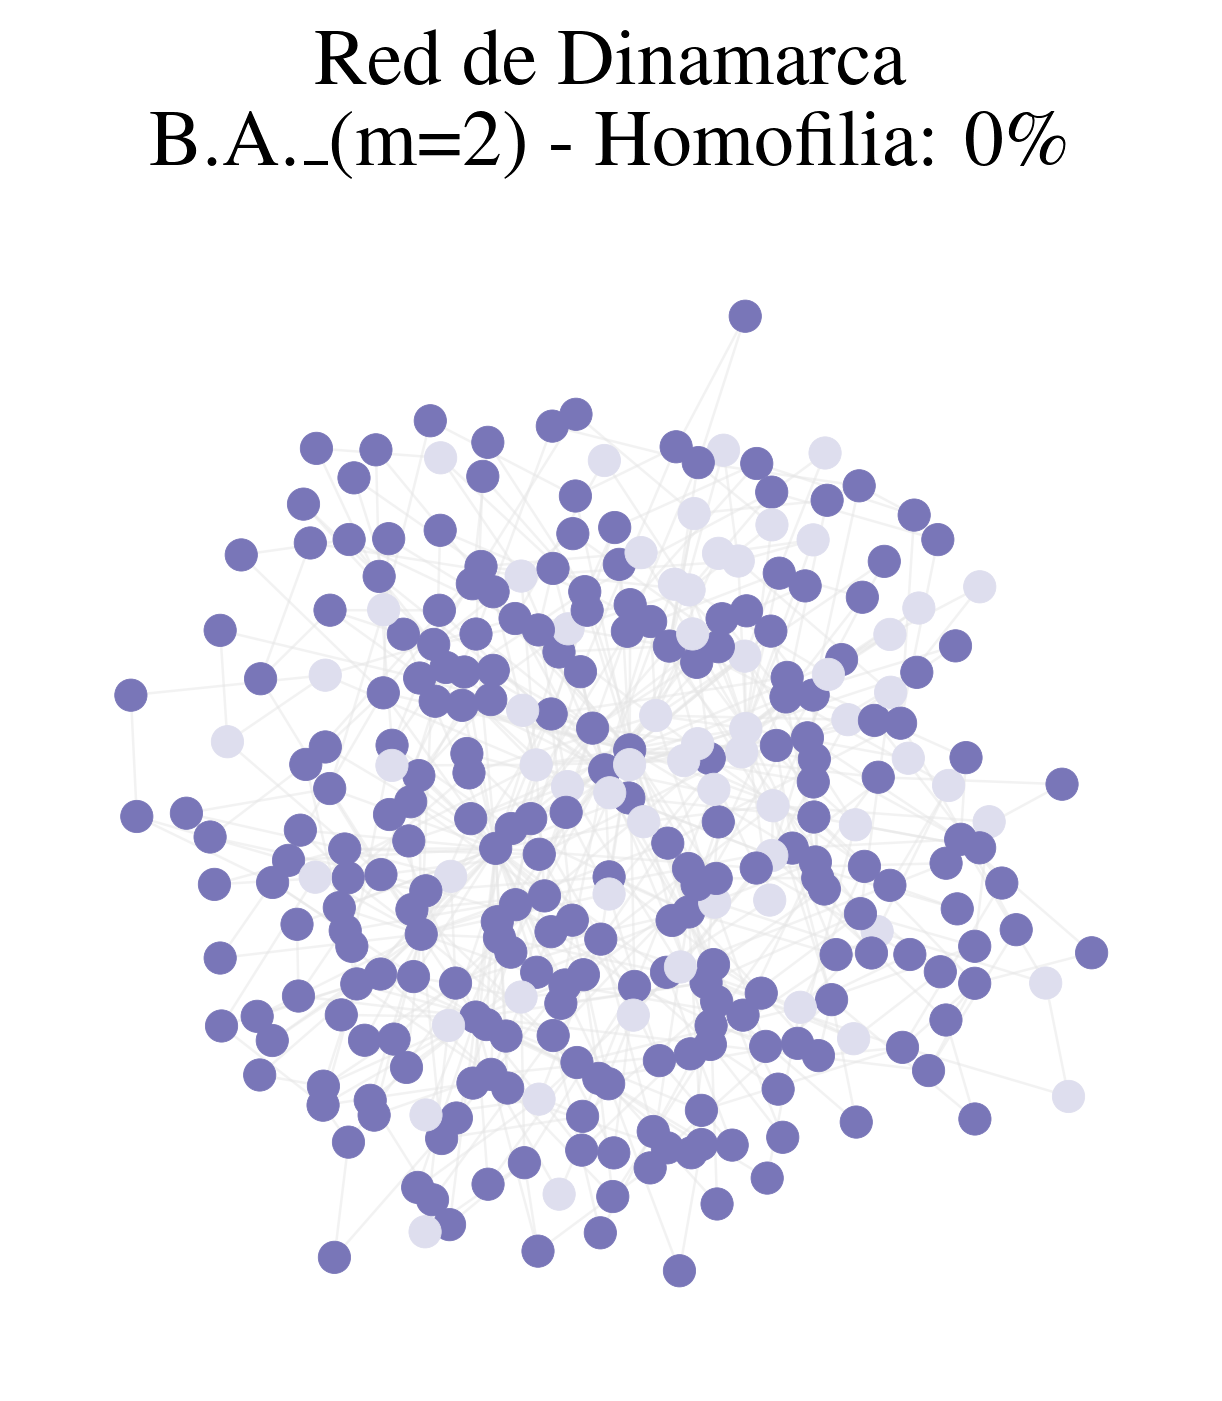

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots
import os
from collections import Counter
# Opcional para mostrar SVG en notebooks
try:
    from IPython.display import SVG, display
except ImportError:
    SVG, display = None, None

# --- Parámetros del Juego de la Corrupción (sin cambios) ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

# --- Funciones Auxiliares (sin cambios) ---
def inicializar_estrategias_corrupcion(n, seed=None):
    if n % 4 != 0: print(f"Advertencia: Nodos ({n}) no div por 4.")
    nodos_por_estrategia = n // 4; estrategias = {}; nodos = list(range(n))
    if seed is not None: random.seed(seed)
    random.shuffle(nodos); idx = 0
    for _ in range(nodos_por_estrategia): estrategias[nodos[idx]] = 'C'; idx += 1
    for _ in range(nodos_por_estrategia): estrategias[nodos[idx]] = 'D'; idx += 1
    for _ in range(nodos_por_estrategia): estrategias[nodos[idx]] = 'H'; idx += 1
    while idx < n: estrategias[nodos[idx]] = 'K'; idx += 1
    return dict(sorted(estrategias.items()))

def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = { ('C', 'C'): r, ('C', 'D'): -s, ('C', 'H'): r, ('C', 'K'): -s, ('D', 'C'): t, ('D', 'D'): 0, ('D', 'H'): t-p, ('D', 'K'): -p, ('H', 'C'): r, ('H', 'D'): -s-c, ('H', 'H'): r, ('H', 'K'): -s-d, ('K', 'C'): t, ('K', 'D'): -c, ('K', 'H'): t-q, ('K', 'K'): -q-d }
    return payoffs.get((strat_i, strat_j), 0)

def actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength):
    estrategia_actual = estrategias[nodo]; recompensa_total_actual = recompensas_totales[nodo]
    vecinos = list(red.neighbors(nodo))
    if not vecinos: return estrategia_actual
    vecino_elegido = random.choice(vecinos); estrategia_vecino = estrategias[vecino_elegido]; recompensa_total_vecino = recompensas_totales[vecino_elegido]
    probabilidad_adoptar_base = 0.0
    try:
        if K <= 1e-9: probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else: delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700); probabilidad_adoptar_base = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError): probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
    if estrategia_actual == estrategia_vecino: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 + homophily_strength)
    else: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 - homophily_strength)
    probabilidad_adoptar_final = np.clip(probabilidad_adoptar_final, 0.0, 1.0)
    return estrategia_vecino if random.random() < probabilidad_adoptar_final else estrategia_actual

# --- Ejecución de Simulación (sin cambios) ---
def ejecutar_simulacion_corrupcion(num_nodos=100, network_type='Completa', network_params=None, params_juego=PARAMS_MEXICO, K=0.1, homophily_strength=0.0, rondas=15, seed=None):
    if seed is not None: random.seed(seed); np.random.seed(seed)
    print(f"Creando red tipo '{network_type}' con {num_nodos} nodos...")
    network_params_str_out = ""
    if network_type == 'Completa': red = nx.complete_graph(num_nodos)
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2)
        if m >= num_nodos: m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed); network_params_str_out = f"_(m={m})"
    else: raise ValueError(f"Tipo de red desconocido: {network_type}")
    print(f"Red creada. Nodos: {red.number_of_nodes()}, Enlaces: {red.number_of_edges()}")
    print(f"Inicializando estrategias (C, D, H, K) con seed={seed}...")
    estrategias = inicializar_estrategias_corrupcion(num_nodos, seed=seed)
    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}; nodos_lista = list(red.nodes())
    print(f"Iniciando {rondas} rondas de simulación con Homofilia={homophily_strength}...")
    for r in range(rondas):
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]; vecinos_i = list(red.neighbors(nodo_i))
            if not vecinos_i: continue
            for nodo_j in vecinos_i: strat_j = estrategias[nodo_j]; recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)
        siguientes_estrategias = {}; nodos_actualizar = nodos_lista[:]; random.shuffle(nodos_actualizar)
        for nodo in nodos_actualizar: siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength)
        estrategias = siguientes_estrategias
        conteo_actual = Counter(estrategias.values())
        for strat in ['C', 'D', 'H', 'K']: fraccion = conteo_actual.get(strat, 0) / num_nodos if num_nodos > 0 else 0; historia_fracciones[strat].append(fraccion)
        if (r + 1) % 50 == 0: print(f"  Ronda {r+1}/{rondas} completada.")
    print("Simulación completada.")
    return historia_fracciones, red, estrategias, network_type, network_params_str_out

# --- Funciones de Graficado (graficar_evolucion y graficar_red_ba sin cambios) ---
def graficar_evolucion_corrupcion(historia_fracciones, titulo, network_type_str, homophily_str, filename):
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(3, 3))
    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'}; nombres_legenda = {'C': 'Civiles Cooperadores (C)', 'D': 'Civiles no Cooperadores (D)', 'H': 'Poder Honrado (H)', 'K': 'Poder Corrupto (K)'}
    rondas_totales = len(historia_fracciones['C']); eje_x = range(rondas_totales)
    for strat in ['C', 'D', 'H', 'K']: plt.plot(eje_x, historia_fracciones[strat], label=nombres_legenda[strat], color=colores[strat], linestyle=estilos[strat], linewidth=1.5)
    plt.xlabel("Iteraciones"); plt.ylabel("Porcentaje"); plt.title(f"Evolución de {titulo}\nRed: {network_type_str} - Homofilia: {homophily_str}")
    plt.ylim(0, 1.0); plt.xlim(0, rondas_totales -1 if rondas_totales > 1 else 1); plt.legend(fontsize='small', loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
    os.makedirs(os.path.dirname(filename), exist_ok=True); plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight'); print(f"Gráfica de evolución guardada como '{filename}'"); plt.close()

def graficar_red_final_ba(red, estrategias_finales, titulo, network_params_str, homophily_str, filename):
    if not isinstance(red, nx.Graph) or not red.nodes(): print(f"Error: No se puede graficar red BA inválida para {titulo}."); return
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5)); n = red.number_of_nodes()
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias_finales.get(nodo, 'Unknown'), '#808080') for nodo in red.nodes()]
    print(f"  Calculando layout para red BA ({n} nodos)..."); pos = nx.spring_layout(red, seed=42, k=0.5/np.sqrt(n))
    print(f"  Dibujando red final BA..."); nx.draw_networkx_nodes(red, pos, node_color=node_colors, node_size=15, linewidths=0.1, edgecolors='face'); nx.draw_networkx_edges(red, pos, edge_color="#E6E6E6", alpha=0.5, width=0.3)
    plt.title(f"Red de {titulo}\nB.A.{network_params_str} - Homofilia: {homophily_str}"); plt.axis('off')
    os.makedirs(os.path.dirname(filename), exist_ok=True); plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight'); print(f"  Gráfica de red BA final guardada como '{filename}'"); plt.close()

# **** Graficar Red Completa - MODIFICADA ****
def graficar_red_final_completa(red, estrategias_finales, titulo, homophily_str, filename):
    """
    Grafica la red Completa final usando spring_layout y dibujando enlaces sutiles.
    ADVERTENCIA: Lento y visualmente denso para N grande.
    """
    if not isinstance(red, nx.Graph) or not red.nodes():
        print(f"Error: No se puede graficar red completa inválida para {titulo}.")
        return

    plt.style.use(['science', 'ieee'])
    plt.figure(figsize=(3, 3)) # Un poco más grande para spring layout
    n = red.number_of_nodes()

    # Colores
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias_finales.get(nodo, 'Unknown'), '#808080') for nodo in red.nodes()]

    # Layout spring (puede ser lento)
    print(f"  Calculando spring_layout para red Completa ({n} nodos)... (puede tardar)")
    try:
        pos = nx.spring_layout(red, seed=42, k=0.5/np.sqrt(n), iterations=30) # Menos iteraciones
    except Exception as e:
        print(f"  Error en spring_layout: {e}. Volviendo a layout circular.")
        pos = nx.circular_layout(red) # Fallback a circular si spring falla

    print(f"  Dibujando red Completa final (nodos y enlaces)...")
    # Dibujar nodos (pequeños)
    nx.draw_networkx_nodes(red, pos, node_color=node_colors, node_size=20,
                           linewidths=0.2, edgecolors='face')

    # --- Dibujar enlaces (muy sutiles) ---
    nx.draw_networkx_edges(red, pos, edge_color="#E6E6E6", alpha=0.1, width=0.1) # Gris claro, muy transparentes y finos

    plt.title(f"Red de {titulo}\nCompleta - Homofilia: {homophily_str}")
    plt.axis('off')

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    # Usar DPI más bajo si SVG es demasiado grande/lento
    plt.savefig(filename, format="png", dpi=300, bbox_inches='tight')
    print(f"  Gráfica de red Completa final guardada como '{filename}'")
    plt.close()


# --- Función Principal (sin cambios desde la versión anterior) ---
def simular_y_graficar_pais(
    nombre_pais, params_juego, num_nodos, network_type, network_params,
    K, homophily_strength, rondas, seed, output_dir="Resultados_Corrupcion",
    graficar_redes_ba=True, graficar_redes_completa=False
    ):
    """Ejecuta simulación y guarda gráficas."""
    print(f"\n--- Sim: {nombre_pais} / {network_type}{network_params} / H={homophily_strength} ---")
    historia, red_final, estrategias_finales, net_type_used, net_params_str = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos, network_type=network_type, network_params=network_params,
        params_juego=params_juego, K=K, homophily_strength=homophily_strength,
        rondas=rondas, seed=seed
    )
    homophily_file_str = f"_h{homophily_strength:.1f}".replace('.', '')
    homophily_title_str = f"{homophily_strength:.1f}"
    nombre_base = f"{nombre_pais.lower().replace(' ', '_')}_{net_type_used}{net_params_str}{homophily_file_str}"
    network_title_str = f"{net_type_used}{net_params_str.replace('_', ' ')}"

    path_grafica_evolucion = os.path.join(output_dir, f"evolucion_{nombre_base}.svg")
    graficar_evolucion_corrupcion(historia, nombre_pais, network_title_str, homophily_title_str, path_grafica_evolucion)

    path_grafica_red_ba = None; path_grafica_red_completa = None
    if net_type_used == 'Barabási-Albert' and graficar_redes_ba:
        path_grafica_red_ba = os.path.join(output_dir, f"red_final_{nombre_base}.svg")
        graficar_red_final_ba(red_final, estrategias_finales, nombre_pais, net_params_str, homophily_title_str, path_grafica_red_ba)
    elif net_type_used == 'Completa' and graficar_redes_completa:
        path_grafica_red_completa = os.path.join(output_dir, f"red_final_{nombre_base}.png")
        graficar_red_final_completa(red_final, estrategias_finales, nombre_pais, homophily_title_str, path_grafica_red_completa) # Llamada a la función modificada

    print(f"--- Simulación para {nombre_pais} en red '{network_type}' con Homofilia={homophily_strength} completada ---")
    return path_grafica_evolucion, path_grafica_red_ba, path_grafica_red_completa


# --- Ejemplo de Uso (sin cambios significativos, asegúrate que GRAFICAR_REDES_COMPLETA sea True si quieres verlas) ---
if __name__ == "__main__":
    # Parámetros globales
    NODOS = 300
    RUIDO_K = 0.0
    RONDAS = 50
    SEED_GLOBAL = 1
    OUTPUT_DIR_GLOBAL = "Resultados_modelo_refinado_Scatà_et_al"
    GRAFICAR_REDES_BA = True # True o False para activarla
    GRAFICAR_REDES_COMPLETA = True # <-- Asegúrate que esté en True

    niveles_homofilia = [0.0, 0.5, 0.8]
    simulaciones_a_ejecutar = [
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 1}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 2}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 3}},
        {'network_type': 'Completa', 'network_params': {}}
    ]
    paths_graficas = {}

    for homophily_level in niveles_homofilia:
        print(f"\n===== INICIANDO SIMULACIONES CON HOMOFILIA = {homophily_level:.1f} =====")
        for sim_config in simulaciones_a_ejecutar:
            net_type = sim_config['network_type']
            net_params = sim_config['network_params']
            net_params_str_dir = "".join([f'_{k}{v}' for k,v in net_params.items()]) if net_params else ""
            homophily_str_dir = f"_h{homophily_level:.1f}".replace('.', '')
            output_subdir = os.path.join(OUTPUT_DIR_GLOBAL, f"Red_{net_type}{net_params_str_dir}{homophily_str_dir}")
            clave_base = f"{net_type}{net_params_str_dir}{homophily_str_dir}"

            for pais, params in [("Dinamarca", PARAMS_DINAMARCA), ("Singapur", PARAMS_SINGAPUR), ("México", PARAMS_MEXICO)]:
                 path_evol, path_red_ba, path_red_completa = simular_y_graficar_pais(
                     pais, params, NODOS, net_type, net_params, RUIDO_K,
                     homophily_level, RONDAS, SEED_GLOBAL, output_subdir,
                     graficar_redes_ba=GRAFICAR_REDES_BA,
                     graficar_redes_completa=GRAFICAR_REDES_COMPLETA # Pasar el flag
                 )
                 # Almacenar paths generados
                 paths_graficas[f"{pais}_{clave_base}_evol"] = path_evol
                 if path_red_ba: paths_graficas[f"{pais}_{clave_base}_red_ba"] = path_red_ba
                 if path_red_completa: paths_graficas[f"{pais}_{clave_base}_red_completa"] = path_red_completa


    print(f"\nTodas las simulaciones completadas. Resultados guardados en subdirectorios dentro de '{OUTPUT_DIR_GLOBAL}'.")

    # Mostrar las gráficas (incluyendo la completa si se generó)
    if display and SVG:
        print("\nMostrando gráficas generadas:")
        claves_ordenadas = sorted(paths_graficas.keys())
        for clave in claves_ordenadas:
            path_grafica = paths_graficas[clave]
            if os.path.exists(path_grafica):
                 nombre_display = clave.replace('_evol', ' Evolución').replace('_red_ba', ' Red BA').replace('_red_completa', ' Red Completa')
                 nombre_display = nombre_display.replace('Barabási-Albert', 'BA').replace('_h0', '_h0.').replace('_h1', '_h1.')
                 print(f"\n--- {nombre_display} ---")
                 try:
                     if os.path.exists(path_grafica) and os.path.getsize(path_grafica) > 0:
                         display(SVG(path_grafica))
                     else:
                         print(f"Archivo SVG no válido o vacío: {path_grafica}")
                 except Exception as e:
                     print(f"Error al mostrar SVG {path_grafica}: {e}")
            else:
                 print(f"Archivo no encontrado: {path_grafica}")
    elif display is None or SVG is None:
        print("\n(Instala IPython/Jupyter para ver las gráficas directamente aquí).")

# Se añade la visualización de las sub-redes creadas únicamente por nodos corruptos (K)

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots
import os
from collections import Counter
import time # Para medir tiempo de layout si es necesario
# Opcional para mostrar SVG en notebooks
try:
    from IPython.display import SVG, display
except ImportError:
    SVG, display = None, None

# --- Parámetros (sin cambios) ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

# --- Funciones Auxiliares (sin cambios) ---
def inicializar_estrategias_corrupcion(n, seed=None):
    if n % 4 != 0: print(f"Advertencia: Nodos ({n}) no div por 4.")
    nodos_por_estrategia = n // 4; estrategias = {}; nodos = list(range(n))
    if seed is not None: random.seed(seed)
    random.shuffle(nodos); idx = 0
    for _ in range(nodos_por_estrategia): estrategias[nodos[idx]] = 'C'; idx += 1
    for _ in range(nodos_por_estrategia): estrategias[nodos[idx]] = 'D'; idx += 1
    for _ in range(nodos_por_estrategia): estrategias[nodos[idx]] = 'H'; idx += 1
    while idx < n: estrategias[nodos[idx]] = 'K'; idx += 1
    return dict(sorted(estrategias.items()))

def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = { ('C', 'C'): r, ('C', 'D'): -s, ('C', 'H'): r, ('C', 'K'): -s, ('D', 'C'): t, ('D', 'D'): 0, ('D', 'H'): t-p, ('D', 'K'): -p, ('H', 'C'): r, ('H', 'D'): -s-c, ('H', 'H'): r, ('H', 'K'): -s-d, ('K', 'C'): t, ('K', 'D'): -c, ('K', 'H'): t-q, ('K', 'K'): -q-d }
    return payoffs.get((strat_i, strat_j), 0)

def actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength):
    estrategia_actual = estrategias[nodo]; recompensa_total_actual = recompensas_totales[nodo]
    vecinos = list(red.neighbors(nodo))
    if not vecinos: return estrategia_actual
    vecino_elegido = random.choice(vecinos); estrategia_vecino = estrategias[vecino_elegido]; recompensa_total_vecino = recompensas_totales[vecino_elegido]
    probabilidad_adoptar_base = 0.0
    try:
        if K <= 1e-9: probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else: delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700); probabilidad_adoptar_base = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError): probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
    if estrategia_actual == estrategia_vecino: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 + homophily_strength)
    else: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 - homophily_strength)
    probabilidad_adoptar_final = np.clip(probabilidad_adoptar_final, 0.0, 1.0)
    return estrategia_vecino if random.random() < probabilidad_adoptar_final else estrategia_actual

# --- Ejecución Simulación (sin cambios) ---
def ejecutar_simulacion_corrupcion(num_nodos=100, network_type='Completa', network_params=None, params_juego=PARAMS_MEXICO, K=0.1, homophily_strength=0.0, rondas=15, seed=None):
    # ... (código igual que antes, devuelve historia, red, estrategias, net_type, net_params_str) ...
    if seed is not None: random.seed(seed); np.random.seed(seed)
    print(f"Creando red tipo '{network_type}' con {num_nodos} nodos...")
    network_params_str_out = ""
    if network_type == 'Completa': red = nx.complete_graph(num_nodos)
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2)
        if m >= num_nodos: m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed); network_params_str_out = f"_(m={m})"
    else: raise ValueError(f"Tipo de red desconocido: {network_type}")
    print(f"Red creada. Nodos: {red.number_of_nodes()}, Enlaces: {red.number_of_edges()}")
    print(f"Inicializando estrategias (C, D, H, K) con seed={seed}...")
    estrategias = inicializar_estrategias_corrupcion(num_nodos, seed=seed)
    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}; nodos_lista = list(red.nodes())
    print(f"Iniciando {rondas} rondas de simulación con Homofilia={homophily_strength}...")
    for r in range(rondas):
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]; vecinos_i = list(red.neighbors(nodo_i))
            if not vecinos_i: continue
            for nodo_j in vecinos_i: strat_j = estrategias[nodo_j]; recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)
        siguientes_estrategias = {}; nodos_actualizar = nodos_lista[:]; random.shuffle(nodos_actualizar)
        for nodo in nodos_actualizar: siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength)
        estrategias = siguientes_estrategias
        conteo_actual = Counter(estrategias.values())
        for strat in ['C', 'D', 'H', 'K']: fraccion = conteo_actual.get(strat, 0) / num_nodos if num_nodos > 0 else 0; historia_fracciones[strat].append(fraccion)
        if (r + 1) % 50 == 0: print(f"  Ronda {r+1}/{rondas} completada.")
    print("Simulación completada.")
    return historia_fracciones, red, estrategias, network_type, network_params_str_out # Devuelve red y estrategias

# --- Funciones de Graficado ---
def graficar_evolucion_corrupcion(historia_fracciones, titulo, network_type_str, homophily_str, filename):
    # ... (código igual que antes) ...
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(3, 3))
    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'}; nombres_legenda = {'C': 'Civiles Cooperadores (C)', 'D': 'Civiles no Cooperadores (D)', 'H': 'Poder Honrado (H)', 'K': 'Poder Corrupto (K)'}
    rondas_totales = len(historia_fracciones['C']); eje_x = range(rondas_totales)
    for strat in ['C', 'D', 'H', 'K']: plt.plot(eje_x, historia_fracciones[strat], label=nombres_legenda[strat], color=colores[strat], linestyle=estilos[strat], linewidth=1.5)
    plt.xlabel("Iteraciones"); plt.ylabel("Porcentaje"); plt.title(f"Evolución de {titulo}\nRed: {network_type_str} - H: {homophily_str}")
    plt.ylim(0, 1.0); plt.xlim(0, rondas_totales -1 if rondas_totales > 1 else 1); plt.legend(fontsize='small', loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
    os.makedirs(os.path.dirname(filename), exist_ok=True); plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight'); print(f"Gráfica de evolución guardada como '{filename}'"); plt.close()

def graficar_red_final(red, estrategias_finales, titulo, network_type, network_params_str, homophily_str, filename):
    """Grafica la red final completa (BA o Completa) y devuelve las posiciones."""
    if not isinstance(red, nx.Graph) or not red.nodes():
        print(f"Error: No se puede graficar red inválida para {titulo}.")
        return None # Devuelve None si no hay red

    plt.style.use(['science', 'ieee'])
    fig_size = (2.5, 2.5) if network_type == 'Completa' else (2.5, 2.5)
    plt.figure(figsize=fig_size)
    n = red.number_of_nodes()

    # Colores y Layout
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias_finales.get(nodo, 'Unknown'), '#808080') for nodo in red.nodes()]

    print(f"  Calculando layout para red {network_type} ({n} nodos)...")
    start_time = time.time()
    try:
        # Usar spring_layout para ambos, ajustar k
        pos = nx.spring_layout(red, seed=42, k=0.6/np.sqrt(n) if n>0 else 0.1, iterations=50 if network_type=='Barabási-Albert' else 30)
    except Exception as e:
        print(f"  Error en spring_layout: {e}. Usando layout circular.")
        pos = nx.circular_layout(red) # Fallback
    print(f"  Layout calculado en {time.time() - start_time:.2f} seg.")

    print(f"  Dibujando red final {network_type}...")
    # Dibujar nodos
    node_size = 15 if network_type == 'Completa' else 25
    nx.draw_networkx_nodes(red, pos, node_color=node_colors, node_size=node_size, linewidths=0.2, edgecolors='face')

    # Dibujar enlaces (más sutiles para completa)
    edge_alpha = 0.05 if network_type == 'Completa' else 0.4
    edge_width = 0.1 if network_type == 'Completa' else 0.5
    nx.draw_networkx_edges(red, pos, edge_color="#cccccc", alpha=edge_alpha, width=edge_width)

    # Título
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type
    plt.title(f"Red de {titulo}\n({title_net_part} - Homofilia : {homophily_str})")
    plt.axis('off')

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    save_format = "png" if network_type == 'Completa' else "svg" # PNG para completa es más manejable
    save_dpi = 300 if network_type == 'Completa' else 300
    plt.savefig(filename, format=save_format, dpi=save_dpi, bbox_inches='tight')
    print(f"  Gráfica de red final guardada como '{filename}' (Formato: {save_format})")
    plt.close()
    return pos # Devolver posiciones calculadas

# **** NUEVA FUNCIÓN PARA GRAFICAR SUBGRAFO K ****
def graficar_subgrafo_k(red_original, estrategias_finales, pos_original, titulo, network_type, network_params_str, homophily_str, filename):
    """Grafica la subred inducida por los nodos con estrategia 'K', manteniendo posiciones originales."""
    nodos_k = [nodo for nodo, strat in estrategias_finales.items() if strat == 'K']

    if not nodos_k:
        print(f"  No se encontraron nodos 'K' para graficar subgrafo en {titulo}.")
        return None

    print(f"  Creando y graficando subgrafo 'K' ({len(nodos_k)} nodos)...")
    subgrafo = red_original.subgraph(nodos_k)

    # Filtrar posiciones
    pos_k = {nodo: pos_original[nodo] for nodo in nodos_k if nodo in pos_original}
    if len(pos_k) != len(nodos_k):
        print("  Advertencia: No se encontraron posiciones para todos los nodos K.")
        # Podría recalcular layout solo para K, pero perdería referencia espacial
        # O graficar solo los que tienen posición
        nodos_a_dibujar = list(pos_k.keys())
        subgrafo = red_original.subgraph(nodos_a_dibujar) # Recrear subgrafo con nodos válidos
        if not nodos_a_dibujar: return None # Salir si no queda ninguno
    else:
        nodos_a_dibujar = nodos_k


    plt.style.use(['science', 'ieee'])
    plt.figure(figsize=(2.5, 2.5)) # Tamaño consistente con red BA

    # Dibujar nodos K (p.ej., en rojo)
    nx.draw_networkx_nodes(subgrafo, pos_k, nodelist=nodos_a_dibujar, node_color='#201F3D', # Color K
                           node_size=20, linewidths=0.2, edgecolors='face')
    # Dibujar enlaces entre nodos K
    nx.draw_networkx_edges(subgrafo, pos_k, edge_color="#7976B8", alpha=0.6, width=0.6) # Color H como enlace? o gris?

    # Título
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type
    plt.title(f"Subgrafo Poder Corrupto (K) - {titulo}\n({title_net_part} - H: {homophily_str})")
    plt.axis('off')

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight')
    print(f"  Gráfica de subgrafo K guardada como '{filename}'")
    plt.close()
    return filename # Devolver path

# --- Función Principal Modificada ---
def simular_y_graficar_pais(
    nombre_pais, params_juego, num_nodos, network_type, network_params,
    K, homophily_strength, rondas, seed, output_dir="Resultados_Corrupcion",
    graficar_redes=True, # Controla AMBAS redes finales
    graficar_subgrafo_k_flag=True # Controla el subgrafo K
    ):
    """
    Ejecuta simulación, guarda gráficas de evolución, red final (si aplica) y subgrafo K (si aplica).
    """
    print(f"\n--- Sim: {nombre_pais} / {network_type}{network_params} / H={homophily_strength} ---")
    # Obtener todos los resultados necesarios
    historia, red_final, estrategias_finales, net_type_used, net_params_str = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos, network_type=network_type, network_params=network_params,
        params_juego=params_juego, K=K, homophily_strength=homophily_strength,
        rondas=rondas, seed=seed
    )
    # Strings para nombres/títulos
    homophily_file_str = f"_h{homophily_strength:.1f}".replace('.', '')
    homophily_title_str = f"{homophily_strength:.1f}"
    nombre_base = f"{nombre_pais.lower().replace(' ', '_')}_{net_type_used}{net_params_str}{homophily_file_str}"
    network_title_str = f"{net_type_used}{net_params_str.replace('_', ' ')}"

    # 1. Graficar Evolución (siempre)
    path_grafica_evolucion = os.path.join(output_dir, f"evolucion_{nombre_base}.svg")
    graficar_evolucion_corrupcion(historia, nombre_pais, network_title_str, homophily_title_str, path_grafica_evolucion)

    # 2. Graficar Red Final (si se solicita) y obtener posiciones
    pos_calculado = None
    path_grafica_red_final = None
    if graficar_redes:
        path_grafica_red_final = os.path.join(output_dir, f"red_final_{nombre_base}.{'png' if net_type_used=='Completa' else 'svg'}")
        # Graficar la red y CAPTURAR las posiciones devueltas
        pos_calculado = graficar_red_final(
            red_final, estrategias_finales, nombre_pais, net_type_used,
            net_params_str, homophily_title_str, path_grafica_red_final
        )

    # 3. Graficar Subgrafo K (si se solicita y hay posiciones)
    path_grafica_subgrafo_k = None
    if graficar_subgrafo_k_flag:
        if pos_calculado is None and graficar_redes: # Si no se graficó red pero se quiere subgrafo, calcular pos ahora
             print("  Calculando posiciones solo para subgrafo K...")
             try:
                 pos_calculado = nx.spring_layout(red_final, seed=42, k=0.6/np.sqrt(num_nodos) if num_nodos>0 else 0.1, iterations=50 if net_type_used=='Barabási-Albert' else 30)
             except Exception as e:
                 print(f"  Error calculando layout para subgrafo K: {e}")
                 pos_calculado = None # No se pudo

        if pos_calculado is not None: # Si tenemos posiciones (calculadas ahora o antes)
            path_grafica_subgrafo_k = os.path.join(output_dir, f"subgrafo_k_{nombre_base}.svg")
            graficar_subgrafo_k(
                red_final, # Red original
                estrategias_finales,
                pos_calculado, # Posiciones originales
                nombre_pais,
                net_type_used,
                net_params_str,
                homophily_title_str,
                path_grafica_subgrafo_k
            )
        else:
             print("  No se pudieron calcular/obtener posiciones, omitiendo subgrafo K.")


    print(f"--- Simulación para {nombre_pais} en red '{network_type}' con H={homophily_strength} completada ---")
    # Devolver todos los paths generados
    return path_grafica_evolucion, path_grafica_red_final, path_grafica_subgrafo_k


# --- Ejemplo de Uso ---
if __name__ == "__main__":
    # Parámetros globales
    NODOS = 100 # Reducir nodos para que las gráficas sean más manejables
    RUIDO_K = 0.0
    RONDAS = 150 # Más rondas para ver mejor la estructura final
    SEED_GLOBAL = 42
    OUTPUT_DIR_GLOBAL = "Resultados_modelo_refinado_Scatà_et_al_con_Subgrafo_K"
    GRAFICAR_REDES_FINALES = True # Graficar BA y Completa
    GRAFICAR_SUBGRAFO_K = True    # Graficar el subgrafo K

    niveles_homofilia = [0.0, 0.5, 0.8]
    simulaciones_a_ejecutar = [
        {'network_type': 'Completa', 'network_params': {}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 1}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 2}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 3}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 4}}
    ]
    paths_graficas = {}

    for homophily_level in niveles_homofilia:
        print(f"\n===== SIMULACIONES CON HOMOFILIA = {homophily_level:.1f} =====")
        for sim_config in simulaciones_a_ejecutar:
            net_type = sim_config['network_type']
            net_params = sim_config['network_params']
            net_params_str_dir = "".join([f'_{k}{v}' for k,v in net_params.items()]) if net_params else ""
            homophily_str_dir = f"_h{homophily_level:.1f}".replace('.', '')
            output_subdir = os.path.join(OUTPUT_DIR_GLOBAL, f"Red_{net_type}{net_params_str_dir}{homophily_str_dir}")
            clave_base = f"{net_type}{net_params_str_dir}{homophily_str_dir}"

            for pais, params in [("Dinamarca", PARAMS_DINAMARCA), ("Singapur", PARAMS_SINGAPUR), ("México", PARAMS_MEXICO)]:
                 path_evol, path_red, path_sub_k = simular_y_graficar_pais(
                     pais, params, NODOS, net_type, net_params, RUIDO_K,
                     homophily_level, RONDAS, SEED_GLOBAL, output_subdir,
                     graficar_redes=GRAFICAR_REDES_FINALES,
                     graficar_subgrafo_k_flag=GRAFICAR_SUBGRAFO_K
                 )
                 # Almacenar paths generados
                 paths_graficas[f"{pais}_{clave_base}_evol"] = path_evol
                 if path_red: paths_graficas[f"{pais}_{clave_base}_red"] = path_red
                 if path_sub_k: paths_graficas[f"{pais}_{clave_base}_subgrafo_k"] = path_sub_k

    print(f"\nTodas las simulaciones completadas. Resultados guardados en '{OUTPUT_DIR_GLOBAL}'.")

    # Mostrar las gráficas
    if display and SVG:
        print("\nMostrando gráficas generadas:")
        claves_ordenadas = sorted(paths_graficas.keys())
        for clave in claves_ordenadas:
            path_grafica = paths_graficas[clave]
            if os.path.exists(path_grafica):
                 nombre_display = clave.replace('_evol', ' Evol.').replace('_red', ' Red').replace('_subgrafo_k', ' Subgrafo K')
                 nombre_display = nombre_display.replace('Barabási-Albert', 'BA').replace('Completa', 'Comp').replace('_h0', '_h0.').replace('_h1', '_h1.')
                 print(f"\n--- {nombre_display} ---")
                 try:
                     # Verificar si es PNG o SVG para display
                     if path_grafica.lower().endswith(".png"):
                         from IPython.display import Image
                         display(Image(filename=path_grafica))
                     elif path_grafica.lower().endswith(".svg"):
                          if os.path.getsize(path_grafica) > 0: display(SVG(path_grafica))
                          else: print(f"Archivo SVG vacío: {path_grafica}")
                     else: print(f"Formato no soportado para display: {path_grafica}")
                 except Exception as e:
                     print(f"Error al mostrar {path_grafica}: {e}")
            else:
                 print(f"Archivo no encontrado: {path_grafica}")
    elif display is None or SVG is None:
        print("\n(Instala IPython/Jupyter para ver las gráficas directamente aquí).")

### Se añade la opción de elegir la posición inicial de la masa inicial de nodos cooperativos (C y H) (Configuración inicial de la masa crítica: central, en los bordes, aleatorio)

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots
import os
from collections import Counter
import time
# Opcional para mostrar SVG en notebooks
try:
    from IPython.display import SVG, display, Image # Añadir Image para PNGs
except ImportError:
    SVG, display, Image = None, None, None

# --- Parámetros Juego (sin cambios) ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

# --- Funciones Auxiliares ---
def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    # ... (código igual que antes) ...
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = { ('C', 'C'): r, ('C', 'D'): -s, ('C', 'H'): r, ('C', 'K'): -s, ('D', 'C'): t, ('D', 'D'): 0, ('D', 'H'): t-p, ('D', 'K'): -p, ('H', 'C'): r, ('H', 'D'): -s-c, ('H', 'H'): r, ('H', 'K'): -s-d, ('K', 'C'): t, ('K', 'D'): -c, ('K', 'H'): t-q, ('K', 'K'): -q-d }
    return payoffs.get((strat_i, strat_j), 0)

def actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength):
    # ... (código igual que antes) ...
    estrategia_actual = estrategias[nodo]; recompensa_total_actual = recompensas_totales[nodo]
    vecinos = list(red.neighbors(nodo))
    if not vecinos: return estrategia_actual
    vecino_elegido = random.choice(vecinos); estrategia_vecino = estrategias[vecino_elegido]; recompensa_total_vecino = recompensas_totales[vecino_elegido]
    probabilidad_adoptar_base = 0.0
    try:
        if K <= 1e-9: probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else: delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700); probabilidad_adoptar_base = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError): probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
    if estrategia_actual == estrategia_vecino: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 + homophily_strength)
    else: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 - homophily_strength)
    probabilidad_adoptar_final = np.clip(probabilidad_adoptar_final, 0.0, 1.0)
    return estrategia_vecino if random.random() < probabilidad_adoptar_final else estrategia_actual

# **** NUEVAS FUNCIONES para Centralidad y Selección CM ****
def calcular_centralidad(red):
    """Calcula centralidad de eigenvector, con fallback a grado."""
    try:
        # Usar tol más grande y más iteraciones puede ayudar
        centrality = nx.eigenvector_centrality_numpy(red)
        print("  Usando centralidad de Eigenvector.")
    except (nx.PowerIterationFailedConvergence, nx.NetworkXError) as e:
        print(f"  Advertencia: Centralidad Eigenvector falló ({e}). Usando centralidad de Grado.")
        centrality = nx.degree_centrality(red)
    return centrality

def seleccionar_nodos_cm(centrality_dict, cm_size, placement_type):
    """Selecciona nodos para la Masa Crítica basado en centralidad."""
    if not 0 < cm_size <= len(centrality_dict):
         raise ValueError(f"Tamaño de Masa Crítica ({cm_size}) inválido para {len(centrality_dict)} nodos.")

    nodos_ordenados = sorted(centrality_dict, key=centrality_dict.get, reverse=(placement_type == 'Nodos centrales'))

    if placement_type == 'Nodos centrales':
        cm_nodes = nodos_ordenados[:cm_size]
    elif placement_type == 'Nodos perifericos': # Cambiado a 'periferico' para claridad
        cm_nodes = nodos_ordenados[:cm_size] # Los primeros al ordenar ascendente (reverse=False)
    elif placement_type == 'Nodos aleatorios':
        cm_nodes = random.sample(list(centrality_dict.keys()), cm_size)
    else:
        raise ValueError(f"Tipo de colocación CM desconocido: {placement_type}")

    return cm_nodes

# **** NUEVA FUNCIÓN de Inicialización de Estrategias con CM ****
def inicializar_estrategias_cm(n, cm_nodes, seed=None):
    """
    Asigna estrategias C y H a nodos CM, y D y K al resto, aproximadamente 50/50.
    """
    if seed is not None:
        random.seed(seed)

    estrategias = {}
    non_cm_nodes = list(set(range(n)) - set(cm_nodes))

    # Mezclar nodos dentro de cada grupo para asignación aleatoria de las dos estrategias
    random.shuffle(cm_nodes)
    random.shuffle(non_cm_nodes)

    # Asignar C/H a CM
    cm_coop1 = 'C'
    cm_coop2 = 'H'
    mitad_cm = len(cm_nodes) // 2
    for i, nodo in enumerate(cm_nodes):
        estrategias[nodo] = cm_coop1 if i < mitad_cm else cm_coop2

    # Asignar D/K a no-CM
    ncm_nocoop1 = 'D'
    ncm_nocoop2 = 'K'
    mitad_ncm = len(non_cm_nodes) // 2
    for i, nodo in enumerate(non_cm_nodes):
        estrategias[nodo] = ncm_nocoop1 if i < mitad_ncm else ncm_nocoop2

    return dict(sorted(estrategias.items())) # Ordenar por ID de nodo

# --- Ejecución Simulación Modificada ---
def ejecutar_simulacion_corrupcion(
    num_nodos=100,
    network_type='Completa',
    network_params=None,
    cm_size=50,             # <--- Nuevo: Tamaño de la Masa Crítica
    cm_placement_type='Nodos aleatorios', # <--- Nuevo: 'central', 'periferico', 'aleatorio'
    params_juego=PARAMS_MEXICO,
    K=0.1,
    homophily_strength=0.0,
    rondas=15,
    seed=None
    ):
    """
    Ejecuta la simulación con inicialización basada en Masa Crítica.
    """
    if seed is not None: random.seed(seed); np.random.seed(seed)

    # 1. Crear Red
    print(f"Creando red tipo '{network_type}' con {num_nodos} nodos...")
    network_params_str_out = ""
    if network_type == 'Completa': red = nx.complete_graph(num_nodos)
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2)
        if m >= num_nodos: m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed); network_params_str_out = f"_(m={m})"
    else: raise ValueError(f"Tipo de red desconocido: {network_type}")
    print(f"Red creada. Nodos: {red.number_of_nodes()}, Enlaces: {red.number_of_edges()}")

    # 2. Calcular Centralidad y Seleccionar CM
    print(f"Calculando centralidad para selección de Masa Crítica...")
    centrality = calcular_centralidad(red)
    print(f"Seleccionando {cm_size} nodos para Masa Crítica (Colocación: {cm_placement_type})...")
    cm_nodes = seleccionar_nodos_cm(centrality, cm_size, cm_placement_type)

    # 3. Inicializar Estrategias Basado en CM
    print(f"Inicializando estrategias (CM={cm_size} C/H, Resto={num_nodos-cm_size} D/K) con seed={seed}...")
    estrategias = inicializar_estrategias_cm(num_nodos, cm_nodes, seed=seed)
    # Verificar inicialización (opcional)
    counts_init = Counter(estrategias.values())
    print(f"  Estrategias iniciales: {counts_init}")


    # 4. Bucle de Simulación (igual que antes)
    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}; nodos_lista = list(red.nodes())
    print(f"Iniciando {rondas} rondas de simulación con H={homophily_strength}, CM={cm_placement_type}...")
    for r in range(rondas):
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]; vecinos_i = list(red.neighbors(nodo_i))
            if not vecinos_i: continue
            for nodo_j in vecinos_i: strat_j = estrategias[nodo_j]; recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)
        siguientes_estrategias = {}; nodos_actualizar = nodos_lista[:]; random.shuffle(nodos_actualizar)
        for nodo in nodos_actualizar: siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength)
        estrategias = siguientes_estrategias # 'estrategias' ahora contiene las finales de esta ronda
        conteo_actual = Counter(estrategias.values())
        for strat in ['C', 'D', 'H', 'K']: fraccion = conteo_actual.get(strat, 0) / num_nodos if num_nodos > 0 else 0; historia_fracciones[strat].append(fraccion)
        # if (r + 1) % 50 == 0: print(f"  Ronda {r+1}/{rondas} completada.") # Descomentar para debug

    print("Simulación completada.")
    # Devolver info de CM para nombres de archivo/títulos
    cm_info_str = f"_({cm_placement_type})" # e.g., _CM50cen
    cm_title_str = f"Posición masa crítica: {cm_placement_type}"
    return historia_fracciones, red, estrategias, network_type, network_params_str_out, cm_info_str, cm_title_str


# --- Funciones de Graficado (actualizadas para incluir info CM) ---
def graficar_evolucion_corrupcion(historia_fracciones, titulo, network_type_str, homophily_str, cm_title_str, filename):
    # ... (código igual que antes, pero añade cm_title_str al título) ...
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'}; nombres_legenda = {'C': '(C) C. Cooperativo', 'D': '(D) C. No Cooperativo', 'H': '(H) P. Honrado', 'K': '(K) P. Corrupto'} # Más corto
    rondas_totales = len(historia_fracciones['C']); eje_x = range(rondas_totales)
    for strat in ['C', 'D', 'H', 'K']: plt.plot(eje_x, historia_fracciones[strat], label=nombres_legenda[strat], color=colores[strat], linestyle=estilos[strat], linewidth=1) # Lineas más finas
    plt.xlabel("Iteraciones"); plt.ylabel("Porcentaje"); #plt.title(f"Evolución de {titulo}\nRed {network_type_str} - Homofilia:{homophily_str}\n{cm_title_str}") # Título completo
    plt.ylim(0, 1.0); plt.xlim(0, rondas_totales -1 if rondas_totales > 1 else 1); plt.legend(fontsize=7, loc='best'); plt.grid(True, linestyle='--', alpha=0.6) # Leyenda más pequeña
    os.makedirs(os.path.dirname(filename), exist_ok=True); plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight'); print(f"Gráfica de evolución guardada como '{filename}'"); plt.close()


def graficar_red_final(red, estrategias_finales, titulo, network_type, network_params_str, homophily_str, cm_title_str, filename):
    # ... (código igual que antes, pero añade cm_title_str al título) ...
    if not isinstance(red, nx.Graph) or not red.nodes(): return None
    plt.style.use(['science', 'ieee']); fig_size = (2.5, 2.5) if network_type == 'Completa' else (2.5, 2.5); plt.figure(figsize=fig_size); n = red.number_of_nodes()
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias_finales.get(nodo, 'Unknown'), '#808080') for nodo in red.nodes()]
    print(f"  Calculando layout para red {network_type} ({n} nodos)..."); start_time = time.time()
    try: pos = nx.spring_layout(red, seed=42, k=0.6/np.sqrt(n) if n>0 else 0.1, iterations=50 if network_type=='Barabási-Albert' else 30)
    except Exception: pos = nx.circular_layout(red)
    print(f"  Layout calculado en {time.time() - start_time:.2f} seg.")
    print(f"  Dibujando red final {network_type}..."); node_size = 10 if network_type == 'Completa' else 15; nx.draw_networkx_nodes(red, pos, node_color=node_colors, node_size=node_size, linewidths=0.1, edgecolors='face')
    edge_alpha = 0.03 if network_type == 'Completa' else 0.4; edge_width = 0.05 if network_type == 'Completa' else 0.3; nx.draw_networkx_edges(red, pos, edge_color="#cccccc", alpha=edge_alpha, width=edge_width)
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type; plt.axis('off'); #plt.title(f"Red de {titulo}\nRed {title_net_part} - Homofilia: {homophily_str}\n{cm_title_str}") # Título completo
    os.makedirs(os.path.dirname(filename), exist_ok=True); save_format = "png" if network_type == 'Completa' else "svg"; save_dpi = 150 if network_type == 'Completa' else 300; plt.savefig(filename, format=save_format, dpi=save_dpi, bbox_inches='tight'); print(f"  Gráfica de red final guardada como '{filename}' (Formato: {save_format})"); plt.close()
    return pos


def graficar_subgrafo_k(red_original, estrategias_finales, pos_original, titulo, network_type, network_params_str, homophily_str, cm_title_str, filename):
    # ... (código igual que antes, pero añade cm_title_str al título) ...
    nodos_k = [nodo for nodo, strat in estrategias_finales.items() if strat == 'K']
    if not nodos_k: print(f"  No nodos 'K' p/ subgrafo en {titulo}."); return None
    print(f"  Creando subgrafo 'K' ({len(nodos_k)} nodos)..."); subgrafo = red_original.subgraph(nodos_k)
    pos_k = {nodo: pos_original[nodo] for nodo in nodos_k if nodo in pos_original}
    if len(pos_k) != len(nodos_k): print(" Adv: No pos para todos K."); nodos_a_dibujar = list(pos_k.keys()); subgrafo = red_original.subgraph(nodos_a_dibujar);
    else: nodos_a_dibujar = nodos_k
    if not nodos_a_dibujar: return None
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    nx.draw_networkx_nodes(subgrafo, pos_k, nodelist=nodos_a_dibujar, node_color='#201F3D', node_size=15, linewidths=0.1, edgecolors='face')
    nx.draw_networkx_edges(subgrafo, pos_k, edge_color="#7976B8", alpha=0.6, width=0.4)
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type; plt.axis('off'); #plt.title(f"Red de nodos corruptos (K) de {titulo}\nRed {title_net_part} - Homofilia: {homophily_str}\n{cm_title_str}") # Título completo
    os.makedirs(os.path.dirname(filename), exist_ok=True); plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight'); print(f"  Gráfica de subgrafo K guardada como '{filename}'"); plt.close()
    return filename

# --- Función Principal Modificada ---
def simular_y_graficar_pais(
    nombre_pais, params_juego, num_nodos,
    network_type, network_params,
    cm_size, cm_placement_type, # <--- Nuevos
    K, homophily_strength, rondas, seed,
    output_dir="Resultados_Corrupcion",
    graficar_redes=True, graficar_subgrafo_k_flag=True
    ):
    """Ejecuta simulación con CM y guarda gráficas."""
    print(f"\n--- Sim: {nombre_pais} / {network_type}{network_params} / CM:{cm_placement_type}({cm_size}) / H={homophily_strength} ---")
    # Ejecutar simulación (ahora devuelve más info)
    historia, red_final, estrategias_finales, net_type_used, net_params_str, cm_info_str, cm_title_str = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos, network_type=network_type, network_params=network_params,
        cm_size=cm_size, cm_placement_type=cm_placement_type, # Pasar params CM
        params_juego=params_juego, K=K, homophily_strength=homophily_strength,
        rondas=rondas, seed=seed
    )
    # Strings para nombres/títulos
    homophily_file_str = f"_h{homophily_strength:.1f}".replace('.', '')
    homophily_title_str = f"{homophily_strength:.1f}"
    # Usar cm_info_str devuelto por ejecutar_simulacion...
    nombre_base = f"{nombre_pais.lower().replace(' ', '_')}_{net_type_used}{net_params_str}{cm_info_str}{homophily_file_str}"
    network_title_str = f"{net_type_used}{net_params_str.replace('_', ' ')}" # Para título

    # 1. Graficar Evolución
    path_grafica_evolucion = os.path.join(output_dir, f"evolucion_{nombre_base}.svg")
    graficar_evolucion_corrupcion(historia, nombre_pais, network_title_str, homophily_title_str, cm_title_str, path_grafica_evolucion)

    # 2. Graficar Red Final (si aplica)
    pos_calculado = None; path_grafica_red_final = None
    if graficar_redes:
        format_red = 'png' if net_type_used == 'Completa' else 'svg'
        path_grafica_red_final = os.path.join(output_dir, f"red_final_{nombre_base}.{format_red}")
        pos_calculado = graficar_red_final(red_final, estrategias_finales, nombre_pais, net_type_used, net_params_str, homophily_title_str, cm_title_str, path_grafica_red_final)

    # 3. Graficar Subgrafo K
    path_grafica_subgrafo_k = None
    if graficar_subgrafo_k_flag:
        if pos_calculado is None and graficar_redes: # Calcular pos si no se hizo antes
             print("  Calculando pos solo para subgrafo K...")
             try: pos_calculado = nx.spring_layout(red_final, seed=seed, k=0.6/np.sqrt(num_nodos) if num_nodos>0 else 0.1, iterations=50 if net_type_used=='Barabási-Albert' else 30)
             except Exception: pos_calculado = None
        if pos_calculado:
            path_grafica_subgrafo_k = os.path.join(output_dir, f"subgrafo_k_{nombre_base}.svg")
            graficar_subgrafo_k(red_final, estrategias_finales, pos_calculado, nombre_pais, net_type_used, net_params_str, homophily_title_str, cm_title_str, path_grafica_subgrafo_k)
        else: print("  No pos, omitiendo subgrafo K.")

    print(f"--- Simulación completada ---")
    return path_grafica_evolucion, path_grafica_red_final, path_grafica_subgrafo_k


# --- Ejemplo de Uso Modificado ---
if __name__ == "__main__":
    # Parámetros globales
    NODOS = 300
    CM_SIZE = NODOS // 2 # Masa crítica inicial = 50% de los nodos
    RUIDO_K = 0.0
    RONDAS = 50
    SEED_GLOBAL = 1
    OUTPUT_DIR_GLOBAL = "Resultados"
    GRAFICAR_REDES_FINALES = True
    GRAFICAR_SUBGRAFO_K = True

    niveles_homofilia = [0.0, 0.5, 0.8]
    config_redes = [
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 1}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 2}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 3}},
        {'network_type': 'Completa', 'network_params': {}}
    ]
    # TIPOS DE COLOCACIÓN CM
    config_cm = ['Nodos centrales', 'Nodos perifericos', 'Nodos aleatorios']

    paths_graficas = {}

    # Bucle Anidado Completo
    for homophily_level in niveles_homofilia:
        print(f"\n===== HOMOFILIA = {homophily_level:.1f} =====")
        for sim_config in config_redes:
            net_type = sim_config['network_type']
            net_params = sim_config['network_params']
            print(f"\n===== RED: {net_type} {net_params} =====")
            for cm_place in config_cm:
                print(f"\n===== CM Placement: {cm_place} =====")

                # Crear directorio específico
                net_params_str_dir = "".join([f'_{k}{v}' for k,v in net_params.items()]) if net_params else ""
                homophily_str_dir = f"_h{homophily_level:.1f}".replace('.', '')
                cm_str_dir = f"_({cm_place})"
                output_subdir = os.path.join(OUTPUT_DIR_GLOBAL, f"Red_{net_type}{net_params_str_dir}{cm_str_dir}{homophily_str_dir}")

                clave_base = f"{net_type}{net_params_str_dir}{cm_str_dir}{homophily_str_dir}"

                # Ejecutar para cada país
                for pais, params in [("Dinamarca", PARAMS_DINAMARCA), ("Singapur", PARAMS_SINGAPUR), ("México", PARAMS_MEXICO)]:
                     path_evol, path_red, path_sub_k = simular_y_graficar_pais(
                         pais, params, NODOS, net_type, net_params,
                         CM_SIZE, cm_place, # Pasar config CM
                         RUIDO_K, homophily_level, RONDAS, SEED_GLOBAL, output_subdir,
                         graficar_redes=GRAFICAR_REDES_FINALES,
                         graficar_subgrafo_k_flag=GRAFICAR_SUBGRAFO_K
                     )
                     # Almacenar paths
                     paths_graficas[f"{pais}_{clave_base}_evol"] = path_evol
                     if path_red: paths_graficas[f"{pais}_{clave_base}_red"] = path_red
                     if path_sub_k: paths_graficas[f"{pais}_{clave_base}_subgrafo_k"] = path_sub_k

    print(f"\nTodas las simulaciones completadas. Resultados en '{OUTPUT_DIR_GLOBAL}'.")
""""
    # Mostrar gráficas
    if display and (SVG or Image):
        print("\nMostrando gráficas generadas:")
        claves_ordenadas = sorted(paths_graficas.keys())
        for clave in claves_ordenadas:
            path_grafica = paths_graficas[clave]
            if os.path.exists(path_grafica):
                 # Limpiar nombre para display
                 nombre_display = clave.replace('_evol', ' Evol').replace('_red', ' Red').replace('_subgrafo_k', ' SubK')
                 nombre_display = nombre_display.replace('Barabási-Albert', 'BA').replace('Completa', 'Comp')
                 nombre_display = nombre_display.replace(f'_CM{CM_SIZE}', '/CM').replace('cen', 'Cen').replace('per', 'Per').replace('ale', 'Ale')
                 nombre_display = nombre_display.replace('_h0', '/H0.').replace('_h1', '/H1.')
                 print(f"\n--- {nombre_display} ---")
                 try:
                     if path_grafica.lower().endswith(".png") and Image: display(Image(filename=path_grafica))
                     elif path_grafica.lower().endswith(".svg") and SVG:
                         if os.path.getsize(path_grafica) > 0: display(SVG(path_grafica))
                         else: print(f"SVG vacío: {path_grafica}")
                     else: print(f"Formato no soportado/librería faltante: {path_grafica}")
                 except Exception as e: print(f"Error display {path_grafica}: {e}")
            else: print(f"No encontrado: {path_grafica}")
    elif display is None or (SVG is None and Image is None):
        print("\n(Instala IPython/Jupyter para ver gráficas).")
"""


===== HOMOFILIA = 0.0 =====

===== RED: Barabási-Albert {'m': 1} =====

===== CM Placement: Nodos centrales =====

--- Sim: Dinamarca / Barabási-Albert{'m': 1} / CM:Nodos centrales(150) / H=0.0 ---
Creando red tipo 'Barabási-Albert' con 300 nodos...
Red creada. Nodos: 300, Enlaces: 299
Calculando centralidad para selección de Masa Crítica...
  Usando centralidad de Eigenvector.
Seleccionando 150 nodos para Masa Crítica (Colocación: Nodos centrales)...
Inicializando estrategias (CM=150 C/H, Resto=150 D/K) con seed=1...
  Estrategias iniciales: Counter({'H': 75, 'C': 75, 'D': 75, 'K': 75})
Iniciando 50 rondas de simulación con H=0.0, CM=Nodos centrales...
Simulación completada.
Gráfica de evolución guardada como 'Resultados\Red_Barabási-Albert_m1_(Nodos centrales)_h00\evolucion_dinamarca_Barabási-Albert_(m=1)_(Nodos centrales)_h00.svg'
  Calculando layout para red Barabási-Albert (300 nodos)...
  Layout calculado en 0.33 seg.
  Dibujando red final Barabási-Albert...
  Gráfica de red fin

'"\n    # Mostrar gráficas\n    if display and (SVG or Image):\n        print("\nMostrando gráficas generadas:")\n        claves_ordenadas = sorted(paths_graficas.keys())\n        for clave in claves_ordenadas:\n            path_grafica = paths_graficas[clave]\n            if os.path.exists(path_grafica):\n                 # Limpiar nombre para display\n                 nombre_display = clave.replace(\'_evol\', \' Evol\').replace(\'_red\', \' Red\').replace(\'_subgrafo_k\', \' SubK\')\n                 nombre_display = nombre_display.replace(\'Barabási-Albert\', \'BA\').replace(\'Completa\', \'Comp\')\n                 nombre_display = nombre_display.replace(f\'_CM{CM_SIZE}\', \'/CM\').replace(\'cen\', \'Cen\').replace(\'per\', \'Per\').replace(\'ale\', \'Ale\')\n                 nombre_display = nombre_display.replace(\'_h0\', \'/H0.\').replace(\'_h1\', \'/H1.\')\n                 print(f"\n--- {nombre_display} ---")\n                 try:\n                     if path_grafica.lower()

### Se pueden seleccionar las estrategias de la masa crítica inicial. 
##### Elegir los jugadores corruptos (K) como masa crítica inicial para analizar la evolución del modelo.

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots
import os
from collections import Counter
import time
# Opcional para mostrar SVG en notebooks
try:
    from IPython.display import SVG, display, Image
except ImportError:
    SVG, display, Image = None, None, None

# --- Parámetros Juego (sin cambios) ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

# --- Funciones Auxiliares ---
def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = { ('C', 'C'): r, ('C', 'D'): -s, ('C', 'H'): r, ('C', 'K'): -s, ('D', 'C'): t, ('D', 'D'): 0, ('D', 'H'): t-p, ('D', 'K'): -p, ('H', 'C'): r, ('H', 'D'): -s-c, ('H', 'H'): r, ('H', 'K'): -s-d, ('K', 'C'): t, ('K', 'D'): -c, ('K', 'H'): t-q, ('K', 'K'): -q-d }
    return payoffs.get((strat_i, strat_j), 0)

def actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength):
    estrategia_actual = estrategias[nodo]; recompensa_total_actual = recompensas_totales[nodo]
    vecinos = list(red.neighbors(nodo))
    if not vecinos: return estrategia_actual
    vecino_elegido = random.choice(vecinos); estrategia_vecino = estrategias[vecino_elegido]; recompensa_total_vecino = recompensas_totales[vecino_elegido]
    probabilidad_adoptar_base = 0.0
    try:
        if K <= 1e-9: probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else: delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700); probabilidad_adoptar_base = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError): probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
    if estrategia_actual == estrategia_vecino: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 + homophily_strength)
    else: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 - homophily_strength)
    probabilidad_adoptar_final = np.clip(probabilidad_adoptar_final, 0.0, 1.0)
    return estrategia_vecino if random.random() < probabilidad_adoptar_final else estrategia_actual

def calcular_centralidad(red):
    try: centrality = nx.eigenvector_centrality_numpy(red); print("  Usando centralidad de Eigenvector.")
    except Exception as e: print(f"  Advertencia: Eigenvector falló ({e}). Usando Grado."); centrality = nx.degree_centrality(red)
    return centrality

def seleccionar_nodos_cm(centrality_dict, cm_size, placement_type):
    if not 0 < cm_size <= len(centrality_dict): raise ValueError(f"CM size ({cm_size}) inválido.")
    # reverse_sort es True solo si queremos los más centrales (orden descendente)
    reverse_sort = (placement_type == 'Nodos centrales')
    nodos_ordenados = sorted(centrality_dict, key=centrality_dict.get, reverse=reverse_sort)

    if placement_type == 'Nodos centrales':
        cm_nodes = nodos_ordenados[:cm_size] # Los primeros N (más centrales)
    elif placement_type == 'Nodos perifericos':
        cm_nodes = nodos_ordenados[:cm_size] # Los primeros N (menos centrales, porque reverse_sort es False)
    elif placement_type == 'Nodos aleatorios':
        cm_nodes = random.sample(list(centrality_dict.keys()), cm_size)
    else:
        raise ValueError(f"Colocación CM desconocida: {placement_type}")
    return cm_nodes

def inicializar_estrategias_cm_flexible(n, cm_nodes, cm_strategies, non_cm_strategies, seed=None):
    if seed is not None: random.seed(seed)
    estrategias = {}; non_cm_nodes = list(set(range(n)) - set(cm_nodes))
    if not cm_strategies: raise ValueError("cm_strategies vacía.")
    if not non_cm_strategies: raise ValueError("non_cm_strategies vacía.")
    random.shuffle(cm_nodes); random.shuffle(non_cm_nodes)
    for i, nodo in enumerate(cm_nodes): estrategias[nodo] = cm_strategies[i % len(cm_strategies)]
    for i, nodo in enumerate(non_cm_nodes): estrategias[nodo] = non_cm_strategies[i % len(non_cm_strategies)]
    return dict(sorted(estrategias.items()))

# --- Ejecución Simulación (Corregida) ---
def ejecutar_simulacion_corrupcion(
    num_nodos=100,
    network_type='Completa', network_params=None,
    cm_size=50, cm_placement_type='Nodos aleatorios',
    cm_strategies = ['C', 'H'], non_cm_strategies = ['D', 'K'],
    params_juego=PARAMS_MEXICO, K=0.1, homophily_strength=0.0,
    rondas=15, seed=None
    ):
    if seed is not None: random.seed(seed); np.random.seed(seed)
    print(f"Creando red tipo '{network_type}'...")
    network_params_str_out = ""
    if network_type == 'Completa': red = nx.complete_graph(num_nodos)
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2)
        if m >= num_nodos: m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed); network_params_str_out = f"_(m={m})"
    else: raise ValueError(f"Tipo de red desconocido: {network_type}")
    print(f"Red creada: {red.number_of_nodes()} nodos, {red.number_of_edges()} enlaces.")
    print(f"Calculando centralidad...")
    centrality = calcular_centralidad(red)
    print(f"Seleccionando {cm_size} nodos CM ({cm_placement_type})...")
    cm_nodes = seleccionar_nodos_cm(centrality, cm_size, cm_placement_type)
    print(f"Inicializando estrategias: CM={cm_strategies}, No-CM={non_cm_strategies} con seed={seed}...")
    estrategias = inicializar_estrategias_cm_flexible(num_nodos, cm_nodes, cm_strategies, non_cm_strategies, seed=seed)
    counts_init = Counter(estrategias.values()); print(f"  Estrategias iniciales: {counts_init}")
    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}; nodos_lista = list(red.nodes())
    print(f"Iniciando {rondas} rondas (H={homophily_strength}, CM={cm_placement_type}, Strats CM={cm_strategies})...")
    for r in range(rondas):
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]; vecinos_i = list(red.neighbors(nodo_i))
            if not vecinos_i: continue
            for nodo_j in vecinos_i: strat_j = estrategias[nodo_j]; recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)
        siguientes_estrategias = {}; nodos_actualizar = nodos_lista[:]; random.shuffle(nodos_actualizar)
        for nodo in nodos_actualizar: siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength)
        estrategias = siguientes_estrategias
        conteo_actual = Counter(estrategias.values())
        for strat_key in ['C', 'D', 'H', 'K']: fraccion = conteo_actual.get(strat_key, 0) / num_nodos if num_nodos > 0 else 0; historia_fracciones[strat_key].append(fraccion)
        if (r + 1) % 50 == 0: print(f"  Ronda {r+1}/{rondas} completada.")
    print("Simulación completada.")
    # --- CORRECCIÓN AQUÍ para cm_info_str ---
    cm_strat_str_file = "".join(sorted(cm_strategies))
    if cm_placement_type == 'Nodos centrales': cm_placement_label_file = "Cen"
    elif cm_placement_type == 'Nodos perifericos': cm_placement_label_file = "Per"
    elif cm_placement_type == 'Nodos aleatorios': cm_placement_label_file = "Ale"
    else: cm_placement_label_file = cm_placement_type[:3].lower()
    cm_info_str = f"_CM{cm_size}{cm_placement_label_file}{cm_strat_str_file}"
    # --- FIN CORRECCIÓN ---
    cm_title_str = f"Masa crítica: {CM_PORCENTAJE}\\% - {cm_placement_type} ({','.join(cm_strategies)})"
    return historia_fracciones, red, estrategias, network_type, network_params_str_out, cm_info_str, cm_title_str

# --- Funciones de Graficado (sin cambios aquí, solo se ajustarán títulos y nombres de archivo) ---
def graficar_evolucion_corrupcion(historia_fracciones, titulo, network_type_str, homophily_str, cm_title_str, filename):
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'}; nombres_legenda = {'C': '(C) C. Coop', 'D': '(D) C. no Coop', 'H': '(H) P. Honrado', 'K': '(K) P. Corrupto'}
    rondas_totales = len(historia_fracciones['C']); eje_x = range(rondas_totales)
    for strat in ['C', 'D', 'H', 'K']: plt.plot(eje_x, historia_fracciones[strat], label=nombres_legenda[strat], color=colores[strat], linestyle=estilos[strat], linewidth=1)
    plt.xlabel("Iteraciones"); plt.ylabel("Porcentaje"); plt.title(f"Evolución de {titulo}\n{network_type_str} - Homofilia: {homophily_str}\\% \n{cm_title_str}")
    plt.ylim(0, 1.0); plt.xlim(0, rondas_totales -1 if rondas_totales > 1 else 1); plt.legend(fontsize=7, loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
    os.makedirs(os.path.dirname(filename), exist_ok=True); plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight'); print(f"Gráfica de evolución guardada como '{filename}'"); plt.close()

def graficar_red_final(red, estrategias_finales, titulo, network_type, network_params_str, homophily_str, cm_title_str, filename):
    if not isinstance(red, nx.Graph) or not red.nodes(): return None
    plt.style.use(['science', 'ieee']); fig_size = (3.5, 3.5) if network_type == 'Completa' else (2.5, 2.5); plt.figure(figsize=fig_size); n = red.number_of_nodes()
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias_finales.get(nodo, 'Unknown'), '#808080') for nodo in red.nodes()]
    print(f"  Calculando layout para red {network_type} ({n} nodos)..."); start_time = time.time()
    try: pos = nx.spring_layout(red, seed=42, k=0.6/np.sqrt(n) if n>0 else 0.1, iterations=50 if network_type=='Barabási-Albert' else 30)
    except Exception: pos = nx.circular_layout(red)
    print(f"  Layout calculado en {time.time() - start_time:.2f} seg.")
    print(f"  Dibujando red final {network_type}..."); node_size = 10 if network_type == 'Completa' else 10; nx.draw_networkx_nodes(red, pos, node_color=node_colors, node_size=node_size, linewidths=0.1, edgecolors='face')
    edge_alpha = 0.5 if network_type == 'Completa' else 0.5; edge_width = 0.5 if network_type == 'Completa' else 0.3; nx.draw_networkx_edges(red, pos, edge_color="#A7A7A7", alpha=edge_alpha, width=edge_width)
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type; plt.title(f"Red de {titulo}\n{title_net_part} - Homofilia: {homophily_str}\\% \n{cm_title_str}"); plt.axis('off')
    os.makedirs(os.path.dirname(filename), exist_ok=True); save_format = "png" if network_type == 'Completa' else "svg"; save_dpi = 150 if network_type == 'Completa' else 300; plt.savefig(filename, format=save_format, dpi=save_dpi, bbox_inches='tight'); print(f"  Gráfica de red final guardada como '{filename}' (Formato: {save_format})"); plt.close()
    return pos

def graficar_subgrafo_k(red_original, estrategias_finales, pos_original, titulo, network_type, network_params_str, homophily_str, cm_title_str, filename):
    nodos_k = [nodo for nodo, strat in estrategias_finales.items() if strat == 'K']
    if not nodos_k: print(f"  No nodos 'K' p/ subgrafo en {titulo}."); return None
    print(f"  Creando subgrafo 'K' ({len(nodos_k)} nodos)..."); subgrafo = red_original.subgraph(nodos_k)
    pos_k = {nodo: pos_original[nodo] for nodo in nodos_k if nodo in pos_original}
    if len(pos_k) != len(nodos_k): print(" Adv: No pos para todos K."); nodos_a_dibujar = list(pos_k.keys()); subgrafo = red_original.subgraph(nodos_a_dibujar);
    else: nodos_a_dibujar = nodos_k
    if not nodos_a_dibujar: return None
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    nx.draw_networkx_nodes(subgrafo, pos_k, nodelist=nodos_a_dibujar, node_color='#201F3D', node_size=10, linewidths=0.1, edgecolors='face')
    nx.draw_networkx_edges(subgrafo, pos_k, edge_color="#201F3D", alpha=0.6, width=0.4)
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type; plt.title(f"Red de nodos corruptos (K) de {titulo}\n{title_net_part} - Homofilia: {homophily_str}\\% \n{cm_title_str}"); plt.axis('off')
    os.makedirs(os.path.dirname(filename), exist_ok=True); plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight'); print(f"  Gráfica de subgrafo K guardada como '{filename}'"); plt.close()
    return filename

# --- Función Principal (Corregida) ---
def simular_y_graficar_pais(
    nombre_pais, params_juego, num_nodos,
    network_type, network_params,
    cm_size, cm_placement_type,
    cm_strategies, non_cm_strategies,
    K, homophily_strength, rondas, seed,
    output_dir="Resultados_Corrupcion",
    graficar_redes=True, graficar_subgrafo_k_flag=True
    ):
    cm_strats_str_label = "".join(sorted(cm_strategies))
    # --- CORRECCIÓN para cm_placement_label ---
    if cm_placement_type == 'Nodos centrales': cm_placement_label = "Cen"
    elif cm_placement_type == 'Nodos perifericos': cm_placement_label = "Per"
    elif cm_placement_type == 'Nodos aleatorios': cm_placement_label = "Ale"
    else: cm_placement_label = cm_placement_type[:3].lower()
    # --- FIN CORRECCIÓN ---
    print(f"\n--- Sim: {nombre_pais} / {network_type}{network_params} / CM:{cm_placement_label}({cm_size} {cm_strats_str_label}) / H={homophily_strength} ---")
    historia, red_final, estrategias_finales, net_type_used, net_params_str_out, cm_info_str, cm_title_str = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos, network_type=network_type, network_params=network_params,
        cm_size=cm_size, cm_placement_type=cm_placement_type, # Pasar el string original
        cm_strategies=cm_strategies, non_cm_strategies=non_cm_strategies,
        params_juego=params_juego, K=K, homophily_strength=homophily_strength,
        rondas=rondas, seed=seed
    )
    homophily_file_str = f"_h{homophily_strength:.1f}".replace('.', '')
    homophily_title_str = f"{homophily_strength:.1f}"
    # Usar cm_info_str (que ahora es único) para el nombre base
    nombre_base = f"{nombre_pais.lower().replace(' ', '_')}_{net_type_used}{net_params_str_out}{cm_info_str}{homophily_file_str}"
    network_title_str = f"{net_type_used}{net_params_str_out.replace('_', ' ')}"

    path_grafica_evolucion = os.path.join(output_dir, f"evolucion_{nombre_base}.svg")
    graficar_evolucion_corrupcion(historia, nombre_pais, network_title_str, homophily_title_str, cm_title_str, path_grafica_evolucion)

    pos_calculado = None; path_grafica_red_final = None
    if graficar_redes:
        format_red = 'png' if net_type_used == 'Completa' else 'svg'
        path_grafica_red_final = os.path.join(output_dir, f"red_final_{nombre_base}.{format_red}")
        pos_calculado = graficar_red_final(red_final, estrategias_finales, nombre_pais, net_type_used, net_params_str_out, homophily_title_str, cm_title_str, path_grafica_red_final)

    path_grafica_subgrafo_k = None
    if graficar_subgrafo_k_flag:
        if pos_calculado is None and graficar_redes:
             print("  Calculando pos solo para subgrafo K...")
             try: pos_calculado = nx.spring_layout(red_final, seed=seed, k=0.6/np.sqrt(num_nodos) if num_nodos>0 else 0.1, iterations=50 if net_type_used=='Barabási-Albert' else 30)
             except Exception: pos_calculado = None
        if pos_calculado:
            path_grafica_subgrafo_k = os.path.join(output_dir, f"subgrafo_k_{nombre_base}.svg")
            graficar_subgrafo_k(red_final, estrategias_finales, pos_calculado, nombre_pais, net_type_used, net_params_str_out, homophily_title_str, cm_title_str, path_grafica_subgrafo_k)
        else: print("  No pos, omitiendo subgrafo K.")
    print(f"--- Simulación completada ---")
    return path_grafica_evolucion, path_grafica_red_final, path_grafica_subgrafo_k

# --- Ejemplo de Uso (Corregido) ---
if __name__ == "__main__":
    NODOS = 1000 # Ajustado para pruebas más rápidas
    CM_SIZE = round((0.5) * NODOS) # Masa crítica inicial, % de los nodos totales de la red
    RUIDO_K = 0.0
    RONDAS = 100 # Ajustado para pruebas más rápidas
    SEED_GLOBAL = 42 # Semilla global para reproducibilidad
    CM_PORCENTAJE = f'{round((CM_SIZE / NODOS) * 100)}'
    OUTPUT_DIR_GLOBAL = f'Resultados_N{NODOS}_I{RONDAS}_CM_{CM_PORCENTAJE}'
    GRAFICAR_REDES_FINALES = True #False, True
    GRAFICAR_SUBGRAFO_K = True #False, True
    
    niveles_homofilia = [0.0] # [0.5, 0.8] # [0.0, 0.5, 0.8] # [0.0, 0.5, 0.8, 0.9] etc.
    config_redes = [
        #{'network_type': 'Completa', 'network_params': {}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 1}},
        #{'network_type': 'Barabási-Albert', 'network_params': {'m': 2}},
        #{'network_type': 'Barabási-Albert', 'network_params': {'m': 3}}
    ]
    config_cm_placement = ['Nodos centrales', 'Nodos perifericos', 'Nodos aleatorios'] #['Nodos centrales']
    config_cm_strategies = [
        #{'label': 'Coop', 'cm_strats': ['C', 'H'], 'non_cm_strats': ['D', 'K']},
        #{'label': 'NoCoop', 'cm_strats': ['D', 'K'], 'non_cm_strats': ['C', 'H']},
        #{'label': 'SoloK', 'cm_strats': ['K'], 'non_cm_strats': ['C', 'D', 'H']},
        {'label': 'KvH', 'cm_strats': ['H'], 'non_cm_strats': [ 'K']},
        {'label': 'KvCH', 'cm_strats': ['H', 'C'], 'non_cm_strats': [ 'K']}
    ]
    paths_graficas = {}

    for cm_strat_config in config_cm_strategies:
        cm_label = cm_strat_config['label']
        cm_strats_list = cm_strat_config['cm_strats']
        non_cm_strats_list = cm_strat_config['non_cm_strats']
        print(f"\n========== MASA CRÍTICA = {cm_label} ({','.join(cm_strats_list)}) ==========")
        for homophily_level in niveles_homofilia:
            print(f"\n===== HOMOFILIA = {homophily_level:.1f} =====")
            for sim_config_red in config_redes: # Renombrar variable para evitar confusión
                net_type = sim_config_red['network_type']
                net_params = sim_config_red['network_params']
                print(f"\n===== RED: {net_type} {net_params} =====")
                for cm_place_type in config_cm_placement: # Renombrar variable
                    print(f"\n===== CM Placement: {cm_place_type} =====")

                    # --- CORRECCIÓN AQUÍ para output_subdir y clave_base ---
                    net_params_str_dir = "".join([f'_{k}{v}' for k,v in net_params.items()]) if net_params else ""
                    homophily_str_dir = f"_h{homophily_level:.1f}".replace('.', '')

                    if cm_place_type == 'Nodos centrales': cm_place_label_dir = "Cen"
                    elif cm_place_type == 'Nodos perifericos': cm_place_label_dir = "Per"
                    elif cm_place_type == 'Nodos aleatorios': cm_place_label_dir = "Ale"
                    else: cm_place_label_dir = cm_place_type[:3].lower() # Fallback

                    cm_place_str_dir = f"_({cm_place_label_dir})"
                    cm_strat_str_dir_label = f"_CM{cm_label}" # Usar el label corto
                    # Estructura de directorios: CM_Tipo / Red_Tipo+Params / Placement+Homofilia
                    output_subdir_base = os.path.join(OUTPUT_DIR_GLOBAL, f"CM_{cm_label}")
                    output_subdir = os.path.join(output_subdir_base, f"Red_{net_type}{net_params_str_dir}", f"{cm_place_label_dir}{homophily_str_dir}")

                    clave_base = f"{net_type}{net_params_str_dir}_{cm_place_label_dir}_{cm_strat_str_dir_label}{homophily_str_dir}"
                    # --- FIN CORRECCIÓN ---

                    for pais, params_juego_pais in [("Dinamarca", PARAMS_DINAMARCA), ("Singapur", PARAMS_SINGAPUR), ("México", PARAMS_MEXICO)]: # Renombrar variable
                         path_evol, path_red, path_sub_k = simular_y_graficar_pais(
                             pais, params_juego_pais, NODOS, net_type, net_params,
                             CM_SIZE, cm_place_type, # Pasar el string original
                             cm_strats_list, non_cm_strats_list,
                             RUIDO_K, homophily_level, RONDAS, SEED_GLOBAL, output_subdir,
                             graficar_redes=GRAFICAR_REDES_FINALES,
                             graficar_subgrafo_k_flag=GRAFICAR_SUBGRAFO_K
                         )
                         paths_graficas[f"{pais}_{clave_base}_evol"] = path_evol
                         if path_red: paths_graficas[f"{pais}_{clave_base}_red"] = path_red
                         if path_sub_k: paths_graficas[f"{pais}_{clave_base}_subgrafo_k"] = path_sub_k
    print(f"\nTodas las simulaciones completadas. Resultados en '{OUTPUT_DIR_GLOBAL}'.")
    
"""
    if display and (SVG or Image):
        print("\nMostrando gráficas generadas:")
        claves_ordenadas = sorted(paths_graficas.keys())
        for clave in claves_ordenadas:
            path_grafica = paths_graficas[clave]
            if os.path.exists(path_grafica):
                 nombre_display = clave.replace('_evol', ' Evol').replace('_red', ' Red').replace('_subgrafo_k', ' SubK')
                 nombre_display = nombre_display.replace('Barabási-Albert', 'BA').replace('Completa', 'Comp')
                 nombre_display = nombre_display.replace('(Cen)', 'Cen').replace('(Per)', 'Per').replace('(Ale)', 'Ale')
                 nombre_display = nombre_display.replace('_CMCoop', '/Coop').replace('_CMNoCoop', '/NoCoop').replace('_CMSoloK', '/SoloK')
                 nombre_display = nombre_display.replace('_h00', '/H0.0').replace('_h05', '/H0.5').replace('_h08', '/H0.8') # Ajuste para homofilia
                 print(f"\n--- {nombre_display} ---")
                 try:
                     if path_grafica.lower().endswith(".png") and Image: display(Image(filename=path_grafica))
                     elif path_grafica.lower().endswith(".svg") and SVG:
                         if os.path.getsize(path_grafica) > 0: display(SVG(path_grafica))
                         else: print(f"SVG vacío: {path_grafica}")
                     else: print(f"Formato no soportado/librería faltante: {path_grafica}")
                 except Exception as e: print(f"Error display {path_grafica}: {e}")
            else: print(f"No encontrado: {path_grafica}")
    elif display is None or (SVG is None and Image is None):
        print("\n(Instala IPython/Jupyter para ver gráficas).")
"""


========== MASA CRÍTICA = KvH (H) ==========

===== HOMOFILIA = 0.0 =====

===== RED: Barabási-Albert {'m': 1} =====

===== CM Placement: Nodos centrales =====

--- Sim: Dinamarca / Barabási-Albert{'m': 1} / CM:Cen(500 H) / H=0.0 ---
Creando red tipo 'Barabási-Albert'...
Red creada: 1000 nodos, 999 enlaces.
Calculando centralidad...
  Usando centralidad de Eigenvector.
Seleccionando 500 nodos CM (Nodos centrales)...
Inicializando estrategias: CM=['H'], No-CM=['K'] con seed=42...
  Estrategias iniciales: Counter({'H': 500, 'K': 500})
Iniciando 100 rondas (H=0.0, CM=Nodos centrales, Strats CM=['H'])...
  Ronda 50/100 completada.
  Ronda 100/100 completada.
Simulación completada.
Gráfica de evolución guardada como 'Resultados_N1000_I100_CM_50\CM_KvH\Red_Barabási-Albert_m1\Cen_h00\evolucion_dinamarca_Barabási-Albert_(m=1)_CM500CenH_h00.svg'
  Calculando layout para red Barabási-Albert (1000 nodos)...
  Layout calculado en 13.00 seg.
  Dibujando red final Barabási-Albert...
  Gráfica de re

'\n    if display and (SVG or Image):\n        print("\nMostrando gráficas generadas:")\n        claves_ordenadas = sorted(paths_graficas.keys())\n        for clave in claves_ordenadas:\n            path_grafica = paths_graficas[clave]\n            if os.path.exists(path_grafica):\n                 nombre_display = clave.replace(\'_evol\', \' Evol\').replace(\'_red\', \' Red\').replace(\'_subgrafo_k\', \' SubK\')\n                 nombre_display = nombre_display.replace(\'Barabási-Albert\', \'BA\').replace(\'Completa\', \'Comp\')\n                 nombre_display = nombre_display.replace(\'(Cen)\', \'Cen\').replace(\'(Per)\', \'Per\').replace(\'(Ale)\', \'Ale\')\n                 nombre_display = nombre_display.replace(\'_CMCoop\', \'/Coop\').replace(\'_CMNoCoop\', \'/NoCoop\').replace(\'_CMSoloK\', \'/SoloK\')\n                 nombre_display = nombre_display.replace(\'_h00\', \'/H0.0\').replace(\'_h05\', \'/H0.5\').replace(\'_h08\', \'/H0.8\') # Ajuste para homofilia\n                

#### Se añade la opción de elegir el país a simular.

In [3]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots
import os
from collections import Counter
import time
# Opcional para mostrar SVG en notebooks
try:
    from IPython.display import SVG, display, Image
except ImportError:
    SVG, display, Image = None, None, None

# --- Parámetros Juego y Funciones (sin cambios) ---

# --- Parámetros Juego ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

# --- Funciones Auxiliares ---
def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = { ('C', 'C'): r, ('C', 'D'): -s, ('C', 'H'): r, ('C', 'K'): -s, ('D', 'C'): t, ('D', 'D'): 0, ('D', 'H'): t-p, ('D', 'K'): -p, ('H', 'C'): r, ('H', 'D'): -s-c, ('H', 'H'): r, ('H', 'K'): -s-d, ('K', 'C'): t, ('K', 'D'): -c, ('K', 'H'): t-q, ('K', 'K'): -q-d }
    return payoffs.get((strat_i, strat_j), 0)

def actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength):
    estrategia_actual = estrategias[nodo]; recompensa_total_actual = recompensas_totales[nodo]
    vecinos = list(red.neighbors(nodo))
    if not vecinos: return estrategia_actual
    vecino_elegido = random.choice(vecinos); estrategia_vecino = estrategias[vecino_elegido]; recompensa_total_vecino = recompensas_totales[vecino_elegido]
    probabilidad_adoptar_base = 0.0
    try:
        if K <= 1e-9: probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else: delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700); probabilidad_adoptar_base = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError): probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
    if estrategia_actual == estrategia_vecino: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 + homophily_strength)
    else: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 - homophily_strength)
    probabilidad_adoptar_final = np.clip(probabilidad_adoptar_final, 0.0, 1.0)
    return estrategia_vecino if random.random() < probabilidad_adoptar_final else estrategia_actual

def calcular_centralidad(red):
    try: centrality = nx.eigenvector_centrality_numpy(red); print("  Usando centralidad de Eigenvector.")
    except Exception as e: print(f"  Advertencia: Eigenvector falló ({e}). Usando Grado."); centrality = nx.degree_centrality(red)
    return centrality

def seleccionar_nodos_cm(centrality_dict, cm_size, placement_type):
    if not 0 < cm_size <= len(centrality_dict): raise ValueError(f"CM size ({cm_size}) inválido.")
    reverse_sort = (placement_type == 'Nodos centrales')
    nodos_ordenados = sorted(centrality_dict, key=centrality_dict.get, reverse=reverse_sort)
    if placement_type in ['Nodos centrales', 'Nodos perifericos']: cm_nodes = nodos_ordenados[:cm_size]
    elif placement_type == 'Nodos aleatorios': cm_nodes = random.sample(list(centrality_dict.keys()), cm_size)
    else: raise ValueError(f"Colocación CM desconocida: {placement_type}")
    return cm_nodes

def inicializar_estrategias_cm_flexible(n, cm_nodes, cm_strategies, non_cm_strategies, seed=None):
    if seed is not None: random.seed(seed)
    estrategias = {}; non_cm_nodes = list(set(range(n)) - set(cm_nodes))
    if not cm_strategies: raise ValueError("cm_strategies vacía.")
    if not non_cm_strategies: raise ValueError("non_cm_strategies vacía.")
    random.shuffle(cm_nodes); random.shuffle(non_cm_nodes)
    for i, nodo in enumerate(cm_nodes): estrategias[nodo] = cm_strategies[i % len(cm_strategies)]
    for i, nodo in enumerate(non_cm_nodes): estrategias[nodo] = non_cm_strategies[i % len(non_cm_strategies)]
    return dict(sorted(estrategias.items()))

# --- Ejecución Simulación (Corregida) ---
def ejecutar_simulacion_corrupcion(
    num_nodos=100,
    network_type='Completa', network_params=None,
    cm_size=50, cm_placement_type='Nodos aleatorios',
    cm_strategies = ['C', 'H'], non_cm_strategies = ['D', 'K'],
    params_juego=PARAMS_MEXICO, K=0.1, homophily_strength=0.0,
    rondas=15, seed=None
    ):
    if seed is not None: random.seed(seed); np.random.seed(seed)
    print(f"Creando red tipo '{network_type}'...")
    network_params_str_out = ""
    if network_type == 'Completa': red = nx.complete_graph(num_nodos)
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2)
        if m >= num_nodos: m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed); network_params_str_out = f"_(m={m})"
    else: raise ValueError(f"Tipo de red desconocido: {network_type}")
    print(f"Red creada: {red.number_of_nodes()} nodos, {red.number_of_edges()} enlaces.")
    print(f"Calculando centralidad...")
    centrality = calcular_centralidad(red)
    print(f"Seleccionando {cm_size} nodos CM ({cm_placement_type})...")
    cm_nodes = seleccionar_nodos_cm(centrality, cm_size, cm_placement_type)
    print(f"Inicializando estrategias: CM={cm_strategies}, No-CM={non_cm_strategies} con seed={seed}...")
    estrategias = inicializar_estrategias_cm_flexible(num_nodos, cm_nodes, cm_strategies, non_cm_strategies, seed=seed)
    counts_init = Counter(estrategias.values()); print(f"  Estrategias iniciales: {counts_init}")
    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}; nodos_lista = list(red.nodes())
    print(f"Iniciando {rondas} rondas (H={homophily_strength}, CM={cm_placement_type}, Strats CM={cm_strategies})...")
    for r in range(rondas):
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]; vecinos_i = list(red.neighbors(nodo_i))
            if not vecinos_i: continue
            for nodo_j in vecinos_i: strat_j = estrategias[nodo_j]; recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)
        siguientes_estrategias = {}; nodos_actualizar = nodos_lista[:]; random.shuffle(nodos_actualizar)
        for nodo in nodos_actualizar: siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength)
        estrategias = siguientes_estrategias
        conteo_actual = Counter(estrategias.values())
        for strat_key in ['C', 'D', 'H', 'K']: fraccion = conteo_actual.get(strat_key, 0) / num_nodos if num_nodos > 0 else 0; historia_fracciones[strat_key].append(fraccion)
        if (r + 1) % 50 == 0: print(f"  Ronda {r+1}/{rondas} completada.")
    print("Simulación completada.")
    cm_strat_str_file = "".join(sorted(cm_strategies))
    if cm_placement_type == 'Nodos centrales': cm_placement_label_file = "Cen"
    elif cm_placement_type == 'Nodos perifericos': cm_placement_label_file = "Per"
    elif cm_placement_type == 'Nodos aleatorios': cm_placement_label_file = "Ale"
    else: cm_placement_label_file = cm_placement_type[:3].lower()
    cm_info_str = f"_CM{cm_size}{cm_placement_label_file}{cm_strat_str_file}"
    cm_title_str = f"Masa crítica: {CM_PORCENTAJE}\\% - {cm_placement_type} ({','.join(cm_strategies)})"
    return historia_fracciones, red, estrategias, network_type, network_params_str_out, cm_info_str, cm_title_str

# --- Funciones de Graficado ---
def graficar_evolucion_corrupcion(historia_fracciones, titulo, network_type_str, homophily_str, cm_title_str, filename):
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'}; nombres_legenda = {'C': '(C) C. Coop', 'D': '(D) C. no Coop', 'H': '(H) P. Honrado', 'K': '(K) P. Corrupto'}
    rondas_totales = len(historia_fracciones['C']); eje_x = range(rondas_totales)
    for strat in ['C', 'D', 'H', 'K']: plt.plot(eje_x, historia_fracciones[strat], label=nombres_legenda[strat], color=colores[strat], linestyle=estilos[strat], linewidth=1)
    plt.xlabel("Iteraciones"); plt.ylabel("Porcentaje"); plt.title(f"Evolución de {titulo}\n{network_type_str} - H: {homophily_str}\\% \n{cm_title_str}")
    plt.ylim(0, 1.0); plt.xlim(0, rondas_totales -1 if rondas_totales > 1 else 1); plt.legend(fontsize=7, loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
    os.makedirs(os.path.dirname(filename), exist_ok=True); plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight'); print(f"Gráfica de evolución guardada como '{filename}'"); plt.close()

def graficar_red_final(red, estrategias_finales, titulo, network_type, network_params_str, homophily_str, cm_title_str, filename):
    if not isinstance(red, nx.Graph) or not red.nodes(): return None
    plt.style.use(['science', 'ieee']); fig_size = (3.5, 3.5) if network_type == 'Completa' else (2.5, 2.5); plt.figure(figsize=fig_size); n = red.number_of_nodes()
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias_finales.get(nodo, 'Unknown'), '#808080') for nodo in red.nodes()]
    print(f"  Calculando layout para red {network_type} ({n} nodos)..."); start_time = time.time()
    try: pos = nx.spring_layout(red, seed=42, k=0.6/np.sqrt(n) if n>0 else 0.1, iterations=50 if network_type=='Barabási-Albert' else 30)
    except Exception: pos = nx.circular_layout(red)
    print(f"  Layout calculado en {time.time() - start_time:.2f} seg.")
    print(f"  Dibujando red final {network_type}..."); node_size = 10 if network_type == 'Completa' else 10; nx.draw_networkx_nodes(red, pos, node_color=node_colors, node_size=node_size, linewidths=0.1, edgecolors='face')
    edge_alpha = 0.5 if network_type == 'Completa' else 0.5; edge_width = 0.5 if network_type == 'Completa' else 0.3; nx.draw_networkx_edges(red, pos, edge_color="#A7A7A7", alpha=edge_alpha, width=edge_width)
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type; plt.title(f"Red de {titulo}\n{title_net_part} - H: {homophily_str}\\% \n{cm_title_str}"); plt.axis('off')
    os.makedirs(os.path.dirname(filename), exist_ok=True); save_format = "png" if network_type == 'Completa' else "svg"; save_dpi = 150 if network_type == 'Completa' else 300; plt.savefig(filename, format=save_format, dpi=save_dpi, bbox_inches='tight'); print(f"  Gráfica de red final guardada como '{filename}' (Formato: {save_format})"); plt.close()
    return pos

def graficar_subgrafo_k(red_original, estrategias_finales, pos_original, titulo, network_type, network_params_str, homophily_str, cm_title_str, filename):
    nodos_k = [nodo for nodo, strat in estrategias_finales.items() if strat == 'K']
    if not nodos_k: print(f"  No nodos 'K' p/ subgrafo en {titulo}."); return None
    print(f"  Creando subgrafo 'K' ({len(nodos_k)} nodos)..."); subgrafo = red_original.subgraph(nodos_k)
    pos_k = {nodo: pos_original[nodo] for nodo in nodos_k if nodo in pos_original}
    if len(pos_k) != len(nodos_k): print(" Adv: No pos para todos K."); nodos_a_dibujar = list(pos_k.keys()); subgrafo = red_original.subgraph(nodos_a_dibujar);
    else: nodos_a_dibujar = nodos_k
    if not nodos_a_dibujar: return None
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    nx.draw_networkx_nodes(subgrafo, pos_k, nodelist=nodos_a_dibujar, node_color='#201F3D', node_size=10, linewidths=0.1, edgecolors='face')
    nx.draw_networkx_edges(subgrafo, pos_k, edge_color="#201F3D", alpha=0.6, width=0.4)
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type; plt.title(f"Red de nodos corruptos (K) de {titulo}\n{title_net_part} - H: {homophily_str}\\% \n{cm_title_str}"); plt.axis('off')
    os.makedirs(os.path.dirname(filename), exist_ok=True); plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight'); print(f"  Gráfica de subgrafo K guardada como '{filename}'"); plt.close()
    return filename

# --- Función Principal (sin cambios) ---
def simular_y_graficar_pais(
    nombre_pais, params_juego, num_nodos,
    network_type, network_params,
    cm_size, cm_placement_type,
    cm_strategies, non_cm_strategies,
    K, homophily_strength, rondas, seed,
    output_dir="Resultados_Corrupcion",
    graficar_redes=True, graficar_subgrafo_k_flag=True
    ):
    cm_strats_str_label = "".join(sorted(cm_strategies))
    if cm_placement_type == 'Nodos centrales': cm_placement_label = "Cen"
    elif cm_placement_type == 'Nodos perifericos': cm_placement_label = "Per"
    elif cm_placement_type == 'Nodos aleatorios': cm_placement_label = "Ale"
    else: cm_placement_label = cm_placement_type[:3].lower()
    print(f"\n--- Sim: {nombre_pais} / {network_type}{network_params} / CM:{cm_placement_label}({cm_size} {cm_strats_str_label}) / H={homophily_strength} ---")
    historia, red_final, estrategias_finales, net_type_used, net_params_str_out, cm_info_str, cm_title_str = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos, network_type=network_type, network_params=network_params,
        cm_size=cm_size, cm_placement_type=cm_placement_type,
        cm_strategies=cm_strategies, non_cm_strategies=non_cm_strategies,
        params_juego=params_juego, K=K, homophily_strength=homophily_strength,
        rondas=rondas, seed=seed
    )
    homophily_file_str = f"_h{homophily_strength:.1f}".replace('.', '')
    homophily_title_str = f"{homophily_strength:.1f}"
    nombre_base = f"{nombre_pais.lower().replace(' ', '_')}_{net_type_used}{net_params_str_out}{cm_info_str}{homophily_file_str}"
    network_title_str = f"{net_type_used}{net_params_str_out.replace('_', ' ')}"
    path_grafica_evolucion = os.path.join(output_dir, f"evolucion_{nombre_base}.svg")
    graficar_evolucion_corrupcion(historia, nombre_pais, network_title_str, homophily_title_str, cm_title_str, path_grafica_evolucion)
    pos_calculado = None; path_grafica_red_final = None
    if graficar_redes:
        format_red = 'png' if net_type_used == 'Completa' else 'svg'
        path_grafica_red_final = os.path.join(output_dir, f"red_final_{nombre_base}.{format_red}")
        pos_calculado = graficar_red_final(red_final, estrategias_finales, nombre_pais, net_type_used, net_params_str_out, homophily_title_str, cm_title_str, path_grafica_red_final)
    path_grafica_subgrafo_k = None
    if graficar_subgrafo_k_flag:
        if pos_calculado is None and graficar_redes:
             print("  Calculando pos solo para subgrafo K...")
             try: pos_calculado = nx.spring_layout(red_final, seed=seed, k=0.6/np.sqrt(num_nodos) if num_nodos>0 else 0.1, iterations=50 if net_type_used=='Barabási-Albert' else 30)
             except Exception: pos_calculado = None
        if pos_calculado:
            path_grafica_subgrafo_k = os.path.join(output_dir, f"subgrafo_k_{nombre_base}.svg")
            graficar_subgrafo_k(red_final, estrategias_finales, pos_calculado, nombre_pais, net_type_used, net_params_str_out, homophily_title_str, cm_title_str, path_grafica_subgrafo_k)
        else: print("  No pos, omitiendo subgrafo K.")
    print(f"--- Simulación completada ---")
    return path_grafica_evolucion, path_grafica_red_final, path_grafica_subgrafo_k


# --- Ejemplo de Uso (Modificado) ---
if __name__ == "__main__":
    # --- Parámetros de Simulación y Control ---
    NODOS = 1000
    CM_PORCENTAJE = 95 # % de los nodos como masa crítica
    RUIDO_K = 0.0
    RONDAS = 100
    SEED_GLOBAL = 42
    OUTPUT_DIR_GLOBAL = f'N{NODOS}_I{RONDAS}_CM_{CM_PORCENTAJE}'
    GRAFICAR_REDES_FINALES = True
    GRAFICAR_SUBGRAFO_K = True

    # --- Selección de Escenarios a Ejecutar ---
    # Para ejecutar todos los países: ['Dinamarca', 'Singapur', 'México']
    # Para ejecutar solo uno: ['México']
    PAISES_A_SIMULAR = ['México']

    # Diccionario central con todos los parámetros de los países
    config_paises = {
        'Dinamarca': PARAMS_DINAMARCA,
        'Singapur': PARAMS_SINGAPUR,
        'México': PARAMS_MEXICO
    }

    niveles_homofilia = [0.0]
    config_redes = [
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 1}}
    ]
    config_cm_placement = ['Nodos centrales', 'Nodos perifericos', 'Nodos aleatorios'] #['Nodos centrales']
    config_cm_strategies = [
        #{'label': 'Coop', 'cm_strats': ['C', 'H'], 'non_cm_strats': ['D', 'K']},
        #{'label': 'NoCoop', 'cm_strats': ['D', 'K'], 'non_cm_strats': ['C', 'H']},
        #{'label': 'SoloK', 'cm_strats': ['K'], 'non_cm_strats': ['C', 'D', 'H']},
        {'label': 'KvH', 'cm_strats': ['H'], 'non_cm_strats': [ 'K']},
        {'label': 'KvCH', 'cm_strats': ['H', 'C'], 'non_cm_strats': [ 'K']}
    ]

    # --- Lógica de Ejecución ---
    CM_SIZE = round((CM_PORCENTAJE / 100) * NODOS)
    paths_graficas = {}

    # Filtrar los países que se van a simular
    paises_filtrados = {pais: config_paises[pais] for pais in PAISES_A_SIMULAR if pais in config_paises}
    if not paises_filtrados:
        print(f"Advertencia: Ninguno de los países seleccionados {PAISES_A_SIMULAR} se encuentra en la configuración. No se ejecutarán simulaciones.")

    # Bucle anidado completo
    for pais, params_juego_pais in paises_filtrados.items():
        print(f"\n==================== PAÍS: {pais.upper()} ====================")
        for cm_strat_config in config_cm_strategies:
            cm_label = cm_strat_config['label']
            cm_strats_list = cm_strat_config['cm_strats']
            non_cm_strats_list = cm_strat_config['non_cm_strats']
            print(f"\n========== MASA CRÍTICA = {cm_label} ({','.join(cm_strats_list)}) ==========")
            for homophily_level in niveles_homofilia:
                print(f"\n===== HOMOFILIA = {homophily_level:.1f} =====")
                for sim_config_red in config_redes:
                    net_type = sim_config_red['network_type']
                    net_params = sim_config_red['network_params']
                    print(f"\n===== RED: {net_type} {net_params} =====")
                    for cm_place_type in config_cm_placement:
                        print(f"\n===== CM Placement: {cm_place_type} =====")

                        if cm_place_type == 'Nodos centrales': cm_place_label_dir = "Cen"
                        elif cm_place_type == 'Nodos perifericos': cm_place_label_dir = "Per"
                        elif cm_place_type == 'Nodos aleatorios': cm_place_label_dir = "Ale"
                        else: cm_place_label_dir = cm_place_type[:3].lower()

                        net_params_str_dir = "".join([f'_{k}{v}' for k,v in net_params.items()]) if net_params else ""
                        homophily_str_dir = f"_h{homophily_level:.1f}".replace('.', '')
                        cm_strat_str_dir_label = f"_CM{cm_label}"
                        # Estructura de directorios: Pais / CM_Tipo / Red_Tipo+Params / Placement+Homofilia
                        output_subdir_base = os.path.join(OUTPUT_DIR_GLOBAL, pais, f"CM_{cm_label}")
                        output_subdir = os.path.join(output_subdir_base, f"Red_{net_type}{net_params_str_dir}", f"{cm_place_label_dir}{homophily_str_dir}")

                        clave_base = f"{pais}_{net_type}{net_params_str_dir}_{cm_place_label_dir}_{cm_strat_str_dir_label}{homophily_str_dir}"

                        path_evol, path_red, path_sub_k = simular_y_graficar_pais(
                             pais, params_juego_pais, NODOS, net_type, net_params,
                             CM_SIZE, cm_place_type,
                             cm_strats_list, non_cm_strats_list,
                             RUIDO_K, homophily_level, RONDAS, SEED_GLOBAL, output_subdir,
                             graficar_redes=GRAFICAR_REDES_FINALES,
                             graficar_subgrafo_k_flag=GRAFICAR_SUBGRAFO_K
                         )
                        paths_graficas[f"{clave_base}_evol"] = path_evol
                        if path_red: paths_graficas[f"{clave_base}_red"] = path_red
                        if path_sub_k: paths_graficas[f"{clave_base}_subgrafo_k"] = path_sub_k

    print(f"\nTodas las simulaciones completadas. Resultados en '{OUTPUT_DIR_GLOBAL}'.")




==================== PAÍS: MÉXICO ====================

========== MASA CRÍTICA = KvH (H) ==========

===== HOMOFILIA = 0.0 =====

===== RED: Barabási-Albert {'m': 1} =====

===== CM Placement: Nodos centrales =====

--- Sim: México / Barabási-Albert{'m': 1} / CM:Cen(950 H) / H=0.0 ---
Creando red tipo 'Barabási-Albert'...
Red creada: 1000 nodos, 999 enlaces.
Calculando centralidad...
  Usando centralidad de Eigenvector.
Seleccionando 950 nodos CM (Nodos centrales)...
Inicializando estrategias: CM=['H'], No-CM=['K'] con seed=42...
  Estrategias iniciales: Counter({'H': 950, 'K': 50})
Iniciando 100 rondas (H=0.0, CM=Nodos centrales, Strats CM=['H'])...
  Ronda 50/100 completada.
  Ronda 100/100 completada.
Simulación completada.
Gráfica de evolución guardada como 'N1000_I100_CM_95\México\CM_KvH\Red_Barabási-Albert_m1\Cen_h00\evolucion_méxico_Barabási-Albert_(m=1)_CM950CenH_h00.svg'
  Calculando layout para red Barabási-Albert (1000 nodos)...
  Layout calculado en 17.82 seg.
  Dibujando

### Se crea  la opción de probar diferentes porcentajes de masa crítica inicial (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)

In [3]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots
import os
from collections import Counter
import time
# Opcional para mostrar SVG en notebooks
try:
    from IPython.display import SVG, display, Image
except ImportError:
    SVG, display, Image = None, None, None

# --- Parámetros Juego y Funciones Auxiliares  ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = { ('C', 'C'): r, ('C', 'D'): -s, ('C', 'H'): r, ('C', 'K'): -s, ('D', 'C'): t, ('D', 'D'): 0, ('D', 'H'): t-p, ('D', 'K'): -p, ('H', 'C'): r, ('H', 'D'): -s-c, ('H', 'H'): r, ('H', 'K'): -s-d, ('K', 'C'): t, ('K', 'D'): -c, ('K', 'H'): t-q, ('K', 'K'): -q-d }
    return payoffs.get((strat_i, strat_j), 0)

def actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength):
    estrategia_actual = estrategias[nodo]; recompensa_total_actual = recompensas_totales[nodo]
    vecinos = list(red.neighbors(nodo))
    if not vecinos: return estrategia_actual
    vecino_elegido = random.choice(vecinos); estrategia_vecino = estrategias[vecino_elegido]; recompensa_total_vecino = recompensas_totales[vecino_elegido]
    probabilidad_adoptar_base = 0.0
    try:
        if K <= 1e-9: probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else: delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700); probabilidad_adoptar_base = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError): probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
    if estrategia_actual == estrategia_vecino: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 + homophily_strength)
    else: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 - homophily_strength)
    probabilidad_adoptar_final = np.clip(probabilidad_adoptar_final, 0.0, 1.0)
    return estrategia_vecino if random.random() < probabilidad_adoptar_final else estrategia_actual

def calcular_centralidad(red):
    try: centrality = nx.eigenvector_centrality_numpy(red); print("  Usando centralidad de Eigenvector.")
    except Exception as e: print(f"  Advertencia: Eigenvector falló ({e}). Usando Grado."); centrality = nx.degree_centrality(red)
    return centrality

def seleccionar_nodos_cm(centrality_dict, cm_size, placement_type):
    if cm_size > len(centrality_dict): raise ValueError(f"CM size ({cm_size}) > num nodos.")
    if cm_size == 0: return []
    reverse_sort = (placement_type == 'Nodos centrales')
    nodos_ordenados = sorted(centrality_dict, key=centrality_dict.get, reverse=reverse_sort)
    if placement_type in ['Nodos centrales', 'Nodos perifericos']: cm_nodes = nodos_ordenados[:cm_size]
    elif placement_type == 'Nodos aleatorios': cm_nodes = random.sample(list(centrality_dict.keys()), cm_size)
    else: raise ValueError(f"Colocación CM desconocida: {placement_type}")
    return cm_nodes

def inicializar_estrategias_cm_flexible(n, cm_nodes, cm_strategies, non_cm_strategies, seed=None):
    if seed is not None: random.seed(seed)
    estrategias = {}; non_cm_nodes = list(set(range(n)) - set(cm_nodes))
    if not cm_strategies: raise ValueError("cm_strategies vacía.")
    if not non_cm_strategies: raise ValueError("non_cm_strategies vacía.")
    random.shuffle(cm_nodes); random.shuffle(non_cm_nodes)
    for i, nodo in enumerate(cm_nodes): estrategias[nodo] = cm_strategies[i % len(cm_strategies)]
    for i, nodo in enumerate(non_cm_nodes): estrategias[nodo] = non_cm_strategies[i % len(non_cm_strategies)]
    return dict(sorted(estrategias.items()))

# --- Ejecución Simulación Modificada ---
def ejecutar_simulacion_corrupcion(
    num_nodos=100,
    network_type='Completa', network_params=None,
    cm_size=50, cm_percentage=50, # <--- Nuevo parámetro para el título
    cm_placement_type='Nodos aleatorios',
    cm_strategies = ['C', 'H'], non_cm_strategies = ['D', 'K'],
    params_juego=PARAMS_MEXICO, K=0.1, homophily_strength=0.0,
    rondas=15, seed=None
    ):
    if seed is not None: random.seed(seed); np.random.seed(seed)
    print(f"Creando red tipo '{network_type}'...")
    network_params_str_out = ""
    if network_type == 'Completa': red = nx.complete_graph(num_nodos)
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2)
        if m >= num_nodos: m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed); network_params_str_out = f"_(m={m})"
    else: raise ValueError(f"Tipo de red desconocido: {network_type}")
    print(f"Red creada: {red.number_of_nodes()} nodos, {red.number_of_edges()} enlaces.")
    print(f"Calculando centralidad...")
    centrality = calcular_centralidad(red)
    print(f"Seleccionando {cm_size} nodos CM ({cm_placement_type})...")
    cm_nodes = seleccionar_nodos_cm(centrality, cm_size, cm_placement_type)
    print(f"Inicializando estrategias: CM={cm_strategies}, No-CM={non_cm_strategies} con seed={seed}...")
    estrategias = inicializar_estrategias_cm_flexible(num_nodos, cm_nodes, cm_strategies, non_cm_strategies, seed=seed)
    counts_init = Counter(estrategias.values()); print(f"  Estrategias iniciales: {counts_init}")
    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}; nodos_lista = list(red.nodes())
    print(f"Iniciando {rondas} rondas...")
    for r in range(rondas):
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]; vecinos_i = list(red.neighbors(nodo_i))
            if not vecinos_i: continue
            for nodo_j in vecinos_i: strat_j = estrategias[nodo_j]; recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)
        siguientes_estrategias = {}; nodos_actualizar = nodos_lista[:]; random.shuffle(nodos_actualizar)
        for nodo in nodos_actualizar: siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength)
        estrategias = siguientes_estrategias
        conteo_actual = Counter(estrategias.values())
        for strat_key in ['C', 'D', 'H', 'K']: fraccion = conteo_actual.get(strat_key, 0) / num_nodos if num_nodos > 0 else 0; historia_fracciones[strat_key].append(fraccion)
    print("Simulación completada.")
    cm_strat_str_file = "".join(sorted(cm_strategies))
    if cm_placement_type == 'Nodos centrales': cm_placement_label_file = "Cen"
    elif cm_placement_type == 'Nodos perifericos': cm_placement_label_file = "Per"
    elif cm_placement_type == 'Nodos aleatorios': cm_placement_label_file = "Ale"
    else: cm_placement_label_file = cm_placement_type[:3].lower()
    # Usar cm_percentage en el nombre del archivo
    cm_info_str = f"_CM{cm_percentage}"
    cm_title_str = f"Masa crítica: {cm_percentage}\\% - {cm_placement_type} ({','.join(cm_strategies)})"
    # --- FIN CORRECCIÓN ---
    return historia_fracciones, red, estrategias, network_type, network_params_str_out, cm_info_str, cm_title_str

# --- Funciones de Graficado  ---
def graficar_evolucion_corrupcion(historia_fracciones, titulo, network_type_str, homophily_str, cm_title_str, filename):
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'}; nombres_legenda = {'C': '(C) C. Coop', 'D': '(D) C. no Coop', 'H': '(H) P. Honrado', 'K': '(K) P. Corrupto'}
    rondas_totales = len(historia_fracciones['C']); eje_x = range(rondas_totales)
    for strat in ['C', 'D', 'H', 'K']: plt.plot(eje_x, historia_fracciones[strat], label=nombres_legenda[strat], color=colores[strat], linestyle=estilos[strat], linewidth=1)
    plt.title(f"Evolución de {titulo}\n{network_type_str} - Homofilia: {int(float(homophily_str) * 100)}\\% \n{cm_title_str}")
    plt.ylim(0, 1.0); plt.xlim(0, rondas_totales -1 if rondas_totales > 1 else 1); plt.legend(fontsize=7, loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
    os.makedirs(os.path.dirname(filename), exist_ok=True); plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight'); print(f"Gráfica de evolución guardada como '{filename}'"); plt.close()

def graficar_red_final(red, estrategias_finales, titulo, network_type, network_params_str, homophily_str, cm_title_str, filename):
    if not isinstance(red, nx.Graph) or not red.nodes(): return None
    plt.style.use(['science', 'ieee']); fig_size = (3.5, 3.5) if network_type == 'Completa' else (2.5, 2.5); plt.figure(figsize=fig_size); n = red.number_of_nodes()
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias_finales.get(nodo, 'Unknown'), '#808080') for nodo in red.nodes()]
    print(f"  Calculando layout para red {network_type} ({n} nodos)..."); start_time = time.time()
    try: pos = nx.spring_layout(red, seed=42, k=0.6/np.sqrt(n) if n>0 else 0.1, iterations=50 if network_type=='Barabási-Albert' else 30)
    except Exception: pos = nx.circular_layout(red)
    print(f"  Layout calculado en {time.time() - start_time:.2f} seg.")
    print(f"  Dibujando red final {network_type}..."); node_size = 10 if network_type == 'Completa' else 10; nx.draw_networkx_nodes(red, pos, node_color=node_colors, node_size=node_size, linewidths=0.1, edgecolors='face')
    edge_alpha = 0.03 if network_type == 'Completa' else 0.5; edge_width = 0.03 if network_type == 'Completa' else 0.3; nx.draw_networkx_edges(red, pos, edge_color="#A7A7A7", alpha=edge_alpha, width=edge_width)
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type; plt.title(f"Red de {titulo}\n{title_net_part} - Homofilia: {int(float(homophily_str) * 100)}\\% \n{cm_title_str}"); plt.axis('off')
    os.makedirs(os.path.dirname(filename), exist_ok=True); save_format = "png" if network_type == 'Completa' else "svg"; save_dpi = 150 if network_type == 'Completa' else 300; plt.savefig(filename, format=save_format, dpi=save_dpi, bbox_inches='tight'); print(f"  Gráfica de red final guardada como '{filename}' (Formato: {save_format})"); plt.close()
    return pos

def graficar_subgrafo_k(red_original, estrategias_finales, pos_original, titulo, network_type, network_params_str, homophily_str, cm_title_str, filename):
    nodos_k = [nodo for nodo, strat in estrategias_finales.items() if strat == 'K']
    if not nodos_k: print(f"  No nodos 'K' p/ subgrafo en {titulo}."); return None
    print(f"  Creando subgrafo 'K' ({len(nodos_k)} nodos)..."); subgrafo = red_original.subgraph(nodos_k)
    pos_k = {nodo: pos_original[nodo] for nodo in nodos_k if nodo in pos_original}
    if len(pos_k) != len(nodos_k): print(" Adv: No pos para todos K."); nodos_a_dibujar = list(pos_k.keys()); subgrafo = red_original.subgraph(nodos_a_dibujar);
    else: nodos_a_dibujar = nodos_k
    if not nodos_a_dibujar: return None
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    nx.draw_networkx_nodes(subgrafo, pos_k, nodelist=nodos_a_dibujar, node_color='#201F3D', node_size=10, linewidths=0.1, edgecolors='face')
    nx.draw_networkx_edges(subgrafo, pos_k, edge_color="#201F3D", alpha=0.6, width=0.4)
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type; plt.title(f"Red de nodos corruptos (K) de {titulo}\n{title_net_part} - Homofilia: {int(float(homophily_str) * 100)}\\% \n{cm_title_str}"); plt.axis('off')
    os.makedirs(os.path.dirname(filename), exist_ok=True); plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight'); print(f"  Gráfica de subgrafo K guardada como '{filename}'"); plt.close()
    return filename

# --- Función Principal Modificada ---
def simular_y_graficar_pais(
    nombre_pais, params_juego, num_nodos,
    network_type, network_params,
    cm_size, cm_percentage, # <--- Nuevo parámetro de porcentaje
    cm_placement_type, cm_strategies, non_cm_strategies,
    K, homophily_strength, rondas, seed,
    output_dir="Resultados_Corrupcion",
    graficar_redes=True, graficar_subgrafo_k_flag=True
    ):
    cm_strats_str_label = "".join(sorted(cm_strategies))
    if cm_placement_type == 'Nodos centrales': cm_placement_label = "Cen"
    elif cm_placement_type == 'Nodos perifericos': cm_placement_label = "Per"
    elif cm_placement_type == 'Nodos aleatorios': cm_placement_label = "Ale"
    else: cm_placement_label = cm_placement_type[:3].lower()
    print(f"\n--- Sim: {nombre_pais} / {network_type}{network_params} / CM:{cm_placement_label}({cm_percentage}% {cm_strats_str_label}) / H={homophily_strength} ---")
    historia, red_final, estrategias_finales, net_type_used, net_params_str_out, cm_info_str, cm_title_str = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos, network_type=network_type, network_params=network_params,
        cm_size=cm_size, cm_percentage=cm_percentage, 
        cm_placement_type=cm_placement_type,
        cm_strategies=cm_strategies, non_cm_strategies=non_cm_strategies,
        params_juego=params_juego, K=K, homophily_strength=homophily_strength,
        rondas=rondas, seed=seed
    )
    homophily_file_str = f"_h{homophily_strength:.2f}".replace('.', '')
    homophily_title_str = f"{homophily_strength:.2f}"
    nombre_base = f"{nombre_pais.lower().replace(' ', '_')}_{net_type_used}{net_params_str_out}{cm_info_str}{homophily_file_str}"
    network_title_str = f"{net_type_used}{net_params_str_out.replace('_', ' ')}"
    path_grafica_evolucion = os.path.join(output_dir, f"evolucion_{nombre_base}.svg")
    graficar_evolucion_corrupcion(historia, nombre_pais, network_title_str, homophily_title_str, cm_title_str, path_grafica_evolucion)
    pos_calculado = None; path_grafica_red_final = None
    if graficar_redes:
        format_red = 'png' if net_type_used == 'Completa' else 'svg'
        path_grafica_red_final = os.path.join(output_dir, f"red_final_{nombre_base}.{format_red}")
        pos_calculado = graficar_red_final(red_final, estrategias_finales, nombre_pais, net_type_used, net_params_str_out, homophily_title_str, cm_title_str, path_grafica_red_final)
    path_grafica_subgrafo_k = None
    if graficar_subgrafo_k_flag:
        if pos_calculado is None and graficar_redes:
             print("  Calculando pos solo para subgrafo K...")
             try: pos_calculado = nx.spring_layout(red_final, seed=seed, k=0.6/np.sqrt(num_nodos) if num_nodos>0 else 0.1, iterations=50 if net_type_used=='Barabási-Albert' else 30)
             except Exception: pos_calculado = None
        if pos_calculado:
            path_grafica_subgrafo_k = os.path.join(output_dir, f"subgrafo_k_{nombre_base}.svg")
            graficar_subgrafo_k(red_final, estrategias_finales, pos_calculado, nombre_pais, net_type_used, net_params_str_out, homophily_title_str, cm_title_str, path_grafica_subgrafo_k)
        else: print("  No pos, omitiendo subgrafo K.")
    print(f"--- Simulación completada ---")
    return path_grafica_evolucion, path_grafica_red_final, path_grafica_subgrafo_k

# --- Ejemplo de Uso  ---
if __name__ == "__main__":
    # --- Parámetros de Simulación y Control ---
    NODOS = 1000
    RUIDO_K = 0.0
    RONDAS = 500
    SEED_GLOBAL = 42
    OUTPUT_DIR_GLOBAL = f'N{NODOS}_I{RONDAS}'
    GRAFICAR_REDES_FINALES = True
    GRAFICAR_SUBGRAFO_K = True

    # --- Selección de Escenarios a Ejecutar ---
    PAISES_A_SIMULAR = ['Singapur']  # Puedes ajustar esta lista para simular solo algunos países ['México', 'Dinamarca', 'Singapur']
    config_paises = {
        'Dinamarca': PARAMS_DINAMARCA,
        'Singapur': PARAMS_SINGAPUR,
        'México': PARAMS_MEXICO
    }

    # ****  Lista de porcentajes de masa crítica a probar ****
    CM_PORCENTAJES_A_PROBAR = [
        #5, 10, 
        #15,
        #20, 
        #25, 
        #30 
        #35, 40, 45, 
        #50, 
        #55, 60, 65, 70, 75, 
        #80, 85, 90,
        95
        #100
        ] # En porcentajes (e.g., 15 para 15%)

    niveles_homofilia = [
        0.0,
        #0.5, 
        #0.8, 
        #0.9,
        #1.0
        ] # Niveles de homofilia a probar [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] etc.
    config_redes = [
        #{'network_type': 'Completa', 'network_params': {}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 1}}
    ]
    config_cm_placement = ['Nodos centrales', 'Nodos perifericos', 'Nodos aleatorios'] #['Nodos centrales', 'Nodos perifericos', 'Nodos aleatorios'] # Puedes ajustar esto según tus necesidades
    config_cm_strategies = [
        #{'label': 'Equilibrio', 'cm_strats': ['C', 'H', 'D', 'K'], 'non_cm_strats': ['C', 'H', 'D', 'K']},
        #{'label': 'Coop', 'cm_strats': ['C', 'H'], 'non_cm_strats': ['D', 'K']},
        #{'label': 'NoCoop', 'cm_strats': ['D', 'K'], 'non_cm_strats': ['C', 'H']},
        {'label': 'SoloK', 'cm_strats': ['K'], 'non_cm_strats': ['C', 'D', 'H']}
        #{'label': 'HvsK', 'cm_strats': ['H'], 'non_cm_strats': [ 'K']},
        #{'label': 'CHvsK', 'cm_strats': ['H', 'C'], 'non_cm_strats': [ 'K']}
    ]

    # --- Lógica de Ejecución ---
    paths_graficas = {}
    paises_filtrados = {pais: config_paises[pais] for pais in PAISES_A_SIMULAR if pais in config_paises}

    # Añadir nuevo bucle para porcentajes de CM
    for cm_percentage in CM_PORCENTAJES_A_PROBAR:
        cm_size = round((cm_percentage / 100) * NODOS)
        if cm_size == 0 and NODOS > 0:
            print(f"Omitiendo CM %={cm_percentage} porque resulta en 0 nodos de masa crítica.")
            continue

        print(f"\n==================== CM PORCENTAJE = {cm_percentage}% (Tamaño={cm_size}) ====================")
        for pais, params_juego_pais in paises_filtrados.items():
            print(f"\n==================== PAÍS: {pais.upper()} ====================")
            for cm_strat_config in config_cm_strategies:
                cm_label = cm_strat_config['label']
                cm_strats_list = cm_strat_config['cm_strats']
                non_cm_strats_list = cm_strat_config['non_cm_strats']
                print(f"\n========== MASA CRÍTICA = {cm_label} ({','.join(cm_strats_list)}) ==========")
                for homophily_level in niveles_homofilia:
                    print(f"\n===== HOMOFILIA = {homophily_level:.2f} =====")
                    for sim_config_red in config_redes:
                        net_type = sim_config_red['network_type']
                        net_params = sim_config_red['network_params']
                        print(f"\n===== RED: {net_type} {net_params} =====")
                        for cm_place_type in config_cm_placement:
                            print(f"\n===== CM Placement: {cm_place_type} =====")

                            if cm_place_type == 'Nodos centrales': cm_place_label_dir = "Cen"
                            elif cm_place_type == 'Nodos perifericos': cm_place_label_dir = "Per"
                            elif cm_place_type == 'Nodos aleatorios': cm_place_label_dir = "Ale"
                            else: cm_place_label_dir = cm_place_type[:3].lower()

                            net_params_str_dir = "".join([f'_{k}{v}' for k,v in net_params.items()]) if net_params else ""
                            homophily_str_dir = f"_h{homophily_level:.2f}".replace('.', '')
                            cm_strat_str_dir_label = f"_CM{cm_label}"
                            cm_percent_str_dir = f"_P{cm_percentage}" # Para el nombre del directorio

                            # Estructura de directorios: Pais / CM_Tipo / CM_Porcentaje / Red_Tipo+Params / Placement+Homofilia
                            output_subdir_base = os.path.join(OUTPUT_DIR_GLOBAL, pais, f"CM_{cm_label}", f"P{cm_percentage}")
                            output_subdir = os.path.join(output_subdir_base, f"Red_{net_type}{net_params_str_dir}", f"{cm_place_label_dir}{homophily_str_dir}")

                            clave_base = f"{pais}_{net_type}{net_params_str_dir}_{cm_place_label_dir}_{cm_strat_str_dir_label}{cm_percent_str_dir}{homophily_str_dir}"

                            path_evol, path_red, path_sub_k = simular_y_graficar_pais(
                                 pais, params_juego_pais, NODOS, net_type, net_params,
                                 cm_size, cm_percentage, # <-- Pasar ambos, tamaño y %
                                 cm_place_type,
                                 cm_strats_list, non_cm_strats_list,
                                 RUIDO_K, homophily_level, RONDAS, SEED_GLOBAL, output_subdir,
                                 graficar_redes=GRAFICAR_REDES_FINALES,
                                 graficar_subgrafo_k_flag=GRAFICAR_SUBGRAFO_K
                             )
                            paths_graficas[f"{clave_base}_evol"] = path_evol
                            if path_red: paths_graficas[f"{clave_base}_red"] = path_red
                            if path_sub_k: paths_graficas[f"{clave_base}_subgrafo_k"] = path_sub_k

    print(f"\nTodas las simulaciones completadas. Resultados en '{OUTPUT_DIR_GLOBAL}'.")


==================== CM PORCENTAJE = 95% (Tamaño=950) ====================

==================== PAÍS: SINGAPUR ====================

========== MASA CRÍTICA = SoloK (K) ==========

===== HOMOFILIA = 0.00 =====

===== RED: Barabási-Albert {'m': 1} =====

===== CM Placement: Nodos centrales =====

--- Sim: Singapur / Barabási-Albert{'m': 1} / CM:Cen(95% K) / H=0.0 ---
Creando red tipo 'Barabási-Albert'...
Red creada: 1000 nodos, 999 enlaces.
Calculando centralidad...
  Usando centralidad de Eigenvector.
Seleccionando 950 nodos CM (Nodos centrales)...
Inicializando estrategias: CM=['K'], No-CM=['C', 'D', 'H'] con seed=42...
  Estrategias iniciales: Counter({'K': 950, 'D': 17, 'C': 17, 'H': 16})
Iniciando 500 rondas...
Simulación completada.
Gráfica de evolución guardada como 'N1000_I500\Singapur\CM_SoloK\P95\Red_Barabási-Albert_m1\Cen_h000\evolucion_singapur_Barabási-Albert_(m=1)_CM95_h000.svg'
  Calculando layout para red Barabási-Albert (1000 nodos)...
  Layout calculado en 12.54 seg.